In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2
index,,,,,,,,,,
AAACCCACATGGCTGC-1_fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050
AAACCCAGTATATGGA-1_fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433
AAACCCAGTCAACACT-1_fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299
AAACCCATCCCGTGAG-1_fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034
AAACCCATCGAACTCA-1_fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702


In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050,fasted,m
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433,fasted,m
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299,fasted,m
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034,fasted,m
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702,fasted,m


In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=25)

adata

AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
"""A metdata columns for a few genes """

label_genes = [
    'Sun1',
    'Mc3r',
    'Agrp',
    'Pomc',
    'Lepr',
]

[print(x) for x in label_genes if not x in adata.var_names]

for gene in label_genes:
    mask = np.ravel(adata[:, [gene]].layers['counts'].todense() > 0)
    adata.obs[gene] = np.where(mask, 1, 0)
    adata.obs[gene] = adata.obs[gene].astype('category')
    print(f"-------- {gene} --------")
    print(adata.obs[gene].value_counts())
    print()

print('Done')

-------- Sun1 --------
1    21714
0    21223
Name: Sun1, dtype: int64

-------- Mc3r --------
0    42175
1      762
Name: Mc3r, dtype: int64

-------- Agrp --------
0    25432
1    17505
Name: Agrp, dtype: int64

-------- Pomc --------
0    31697
1    11240
Name: Pomc, dtype: int64

-------- Lepr --------
0    35836
1     7101
Name: Lepr, dtype: int64

Done


In [7]:
key = 'Diet'
# get marker genes
sc.tl.rank_genes_groups(adata, 
                        groupby=key,
                        method='wilcoxon',
                        key_added=key,
                        corr_method='benjamini-hochberg')

deg = sc.get.rank_genes_groups_df(adata, 
                                  group='fasted',
                                  key=key)

deg.head()

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


,names,scores,logfoldchanges,pvals,pvals_adj
0,Srsf10,55.261013,0.849130,0.0,0.0
1,Gm26871,52.240036,0.927264,0.0,0.0
2,Npy,49.007404,2.572269,0.0,0.0
3,Peg3,48.906406,0.622618,0.0,0.0
4,Gabrb3,45.597534,0.632454,0.0,0.0


In [8]:
alpha = 0.05
n_print = 20
pdf = deg.copy()
pdf = pdf.sort_values(by='logfoldchanges', ascending=False)
pdf = pdf[pdf['pvals_adj'] <= alpha]

print(f"----- Upregulated genes in fasted cells -----")
print(pdf[['names', 'logfoldchanges']].head(n_print))

print()
print(f"----- Downregulated genes in fasted cells -----")
print(pdf[['names', 'logfoldchanges']].tail(n_print))


----- Upregulated genes in fasted cells -----
        names  logfoldchanges
5436  Slco1a1        6.442300
2087   Atp1a4        3.649169
6071     Hao1        3.141992
6201  Olfr920        3.001123
2         Npy        2.572269
3172    Meiob        2.544060
4555  Gm47214        2.501366
2346   Cdkn1a        2.418248
4539  Gm31456        2.405923
3771  Gm20647        2.302967
5466    Ccl17        2.301496
5792    Tigit        2.240003
6099  Gm49735        2.205239
6251    Tex35        2.151994
681     Casq1        2.130793
6862  Gm10280        2.045630
1679    Corin        2.039736
5847  Gm13544        2.028910
1040  Gm44577        1.928171
4755    Itgad        1.839876

----- Downregulated genes in fasted cells -----
               names  logfoldchanges
23842        Gm13905       -1.552601
23607          Gpr17       -1.559155
24990           Gjc3       -1.565940
24382        Gm10863       -1.579214
24611          Lpar1       -1.588886
23845        Gm48370       -1.590613
23951        Gm1

In [9]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05
n_query = 300

query_genes = pdf['names'].tail(n_query).to_list()

edf = gget.enrichr(query_genes, database=db)
pd.set_option('display.max_colwidth', 150)
print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(30))
print()

Tue Oct 24 15:01:18 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


                                                                               path_name  \
0                                                               myelination (GO:0042552)   
1                                        central nervous system development (GO:0007417)   
2                                                nervous system development (GO:0007399)   
3                                                glial cell differentiation (GO:0010001)   
4                             regulation of oligodendrocyte differentiation (GO:0048713)   
5                               axon ensheathment in central nervous system (GO:0032291)   
6                    negative regulation of oligodendrocyte differentiation (GO:0048715)   
7                         negative regulation of glial cell differentiation (GO:0045686)   
8                                           oligodendrocyte differentiation (GO:0048709)   
9                                        central nervous system myelination (GO:

/tmp/ipykernel_568497/510778054.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['logp'] = -1 * np.log10(cdf['adj_p_val'])
/tmp/ipykernel_568497/510778054.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf['pname'] = cdf['path_name'].apply(lambda x: x.split("(")[0].strip().title())


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,logp,pname
0,1,myelination (GO:0042552),9.939030e-11,20.227532,465.879843,"[GAL3ST1, MYRF, PLLP, PLP1, PMP22, MAL, MBP, ACSBG1, SOX10, HES5, BCAS1]",1.893385e-07,GO_Biological_Process_2021,6.722761,Myelination
1,2,central nervous system development (GO:0007417),7.617918e-10,5.927953,124.459428,"[GSN, MYRF, MOG, SYNJ2, SOX10, MEIS2, POU3F3, HAPLN2, NR4A2, BCAN, MEIS1, NFIB, ZIC1, MAL, SOX8, APOD, PHGDH, MBP, SOX6, DSCAML1, HES5]",6.019160e-07,GO_Biological_Process_2021,6.220464,Central Nervous System Development
2,3,nervous system development (GO:0007399),9.478993e-10,4.540031,94.327201,"[LPAR1, PTN, HAPLN2, EDNRB, MOBP, ERBB3, ZIC1, HES1, SOX8, MBP, SOX6, HES5, GSN, MOG, SOX10, POU3F3, VEGFA, BCAN, ZEB2, GJB1, NINJ2, LHX1, PMP22, ...",6.019160e-07,GO_Biological_Process_2021,6.220464,Nervous System Development
3,4,glial cell differentiation (GO:0010001),7.621255e-09,25.673842,479.903795,"[SOX2, MYRF, ERBB3, METRN, NFIB, SOX8, SOX10, HES5]",3.629623e-06,GO_Biological_Process_2021,5.440139,Glial Cell Differentiation
4,5,regulation of oligodendrocyte differentiation (GO:0048713),2.494272e-07,30.905808,469.894959,"[NOTCH1, TMEM98, OPALIN, HES1, PTN, HES5]",9.503178e-05,GO_Biological_Process_2021,4.022131,Regulation Of Oligodendrocyte Differentiation


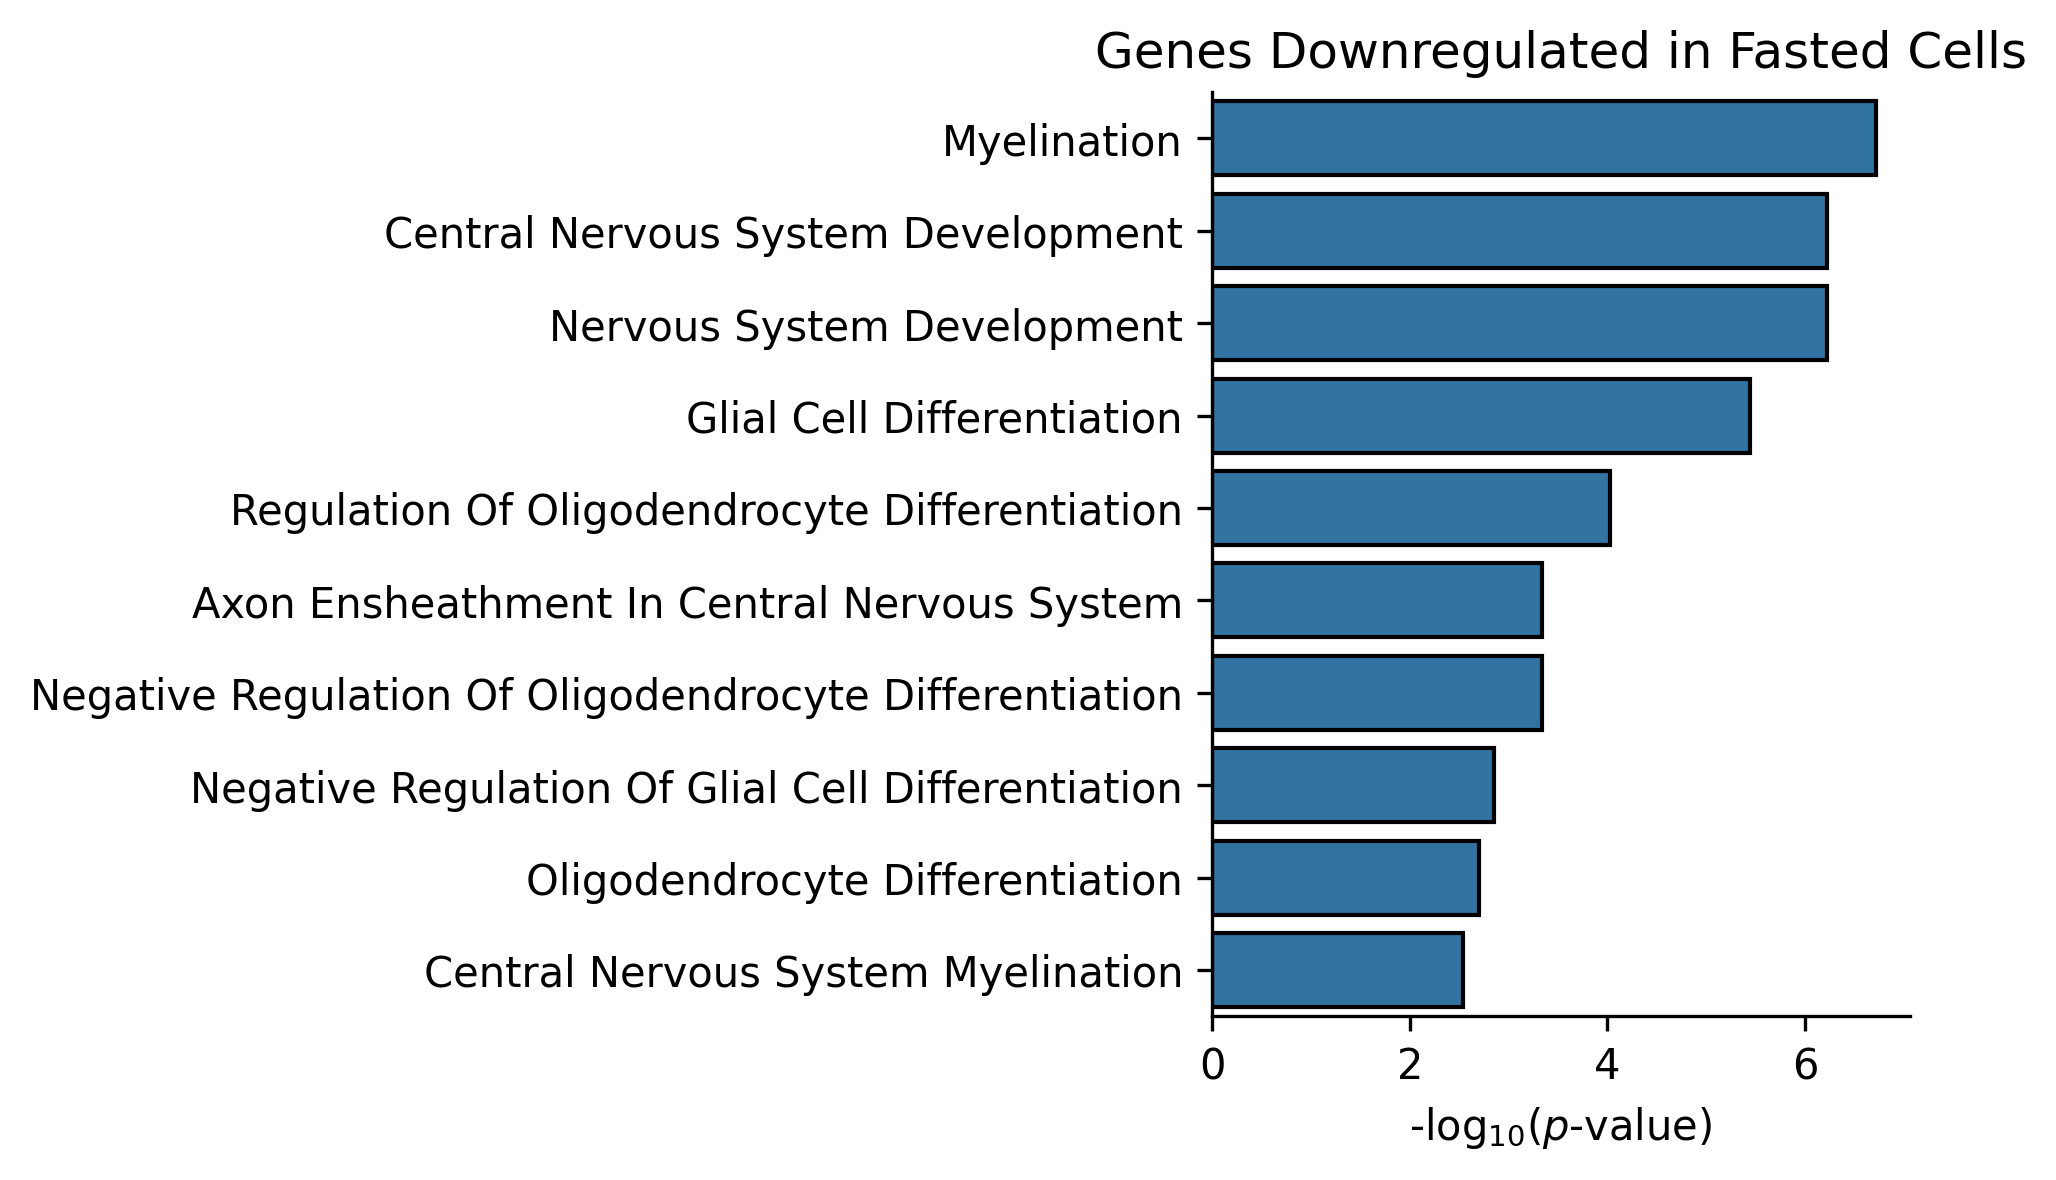

In [10]:
n_plot = 20
cdf = edf.head(10)
cdf['logp'] = -1 * np.log10(cdf['adj_p_val'])

cdf['pname'] = cdf['path_name'].apply(lambda x: x.split("(")[0].strip().title())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(data=cdf, 
            x='logp',
            y='pname',
            ec='k',
            color='C0')

plt.ylabel("")
plt.xlabel(r"-log$_{10}$($p$-value)")
plt.title("Genes Downregulated in Fasted Cells")
sns.despine()
cdf.head()

In [11]:
outpath = "fasted_DEG_GSE.csv"
edf[['path_name', 'overlapping_genes', 'adj_p_val']].to_csv(outpath, index=False)

edf.head()

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,myelination (GO:0042552),9.939030e-11,20.227532,465.879843,"[GAL3ST1, MYRF, PLLP, PLP1, PMP22, MAL, MBP, ACSBG1, SOX10, HES5, BCAS1]",1.893385e-07,GO_Biological_Process_2021
1,2,central nervous system development (GO:0007417),7.617918e-10,5.927953,124.459428,"[GSN, MYRF, MOG, SYNJ2, SOX10, MEIS2, POU3F3, HAPLN2, NR4A2, BCAN, MEIS1, NFIB, ZIC1, MAL, SOX8, APOD, PHGDH, MBP, SOX6, DSCAML1, HES5]",6.019160e-07,GO_Biological_Process_2021
2,3,nervous system development (GO:0007399),9.478993e-10,4.540031,94.327201,"[LPAR1, PTN, HAPLN2, EDNRB, MOBP, ERBB3, ZIC1, HES1, SOX8, MBP, SOX6, HES5, GSN, MOG, SOX10, POU3F3, VEGFA, BCAN, ZEB2, GJB1, NINJ2, LHX1, PMP22, ...",6.019160e-07,GO_Biological_Process_2021
3,4,glial cell differentiation (GO:0010001),7.621255e-09,25.673842,479.903795,"[SOX2, MYRF, ERBB3, METRN, NFIB, SOX8, SOX10, HES5]",3.629623e-06,GO_Biological_Process_2021
4,5,regulation of oligodendrocyte differentiation (GO:0048713),2.494272e-07,30.905808,469.894959,"[NOTCH1, TMEM98, OPALIN, HES1, PTN, HES5]",9.503178e-05,GO_Biological_Process_2021


In [12]:
# db = 'WikiPathways_2019_Mouse'
db = 'Allen_Brain_Atlas_10x_scRNA_2021'

e_alpha = 0.05
n_query = 500

query_genes = pdf['names'].tail(n_query).to_list()

edf = gget.enrichr(query_genes, database=db)
print(edf[['path_name', 'adj_p_val']].head(30))
# print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(30))
print()

Tue Oct 24 15:01:20 2023 INFO Performing Enichr analysis using database Allen_Brain_Atlas_10x_scRNA_2021.


                             path_name     adj_p_val
0                   Mouse 367 Oligo up  1.981126e-18
1                   Mouse 366 Oligo up  1.292776e-16
2   Human Oligo L5-6 OPALIN LDLRAP1 up  3.398821e-10
3                   Mouse 368 Oligo up  5.155424e-10
4                   Mouse 365 Oligo up  3.543851e-09
5     Human Oligo L3-6 OPALIN ENPP6 up  4.140196e-09
6                   Mouse 364 Oligo up  3.447284e-08
7                   Mouse 356 Astro up  1.392992e-06
8    Human Oligo L2-6 OPALIN FTH1P3 up  5.340903e-06
9                   Mouse 363 Oligo up  1.913965e-05
10                  Mouse 361 Oligo up  9.266440e-05
11                  Mouse 358 Astro up  2.942923e-04
12                  Mouse 362 Oligo up  5.556666e-04
13    Human OPC L1-6 PDGFRA COL20A1 up  1.394971e-03
14   Human VLMC L1-5 PDGFRA COLEC12 up  2.662230e-03
15                   Mouse 369 Endo up  2.077904e-02
16                   Mouse 371 Peri up  2.077904e-02
17             Mouse 141 L3 IT ENTm up  2.0810

In [13]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# By Sex

In [14]:
alpha = 0.05
plot_top = 10
lcft = 2
key = 'Diet'

sexes = [
    'm',
    'f',
]

res = []

for sex in sexes:
    print(f"\n-------- {sex} mice --------")
    tmp = adata[adata.obs["Sex"] == sex] 

    # get marker genes
    sc.tl.rank_genes_groups(tmp, 
                            groupby=key,
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')


    deg = sc.get.rank_genes_groups_df(tmp, 
                                      group='fasted',
                                      key=key)

    deg['sex'] = sex
    res.append(deg)
    pdf = deg.copy()
    pdf = pdf.sort_values(by='logfoldchanges', ascending=False)
    pdf = pdf[pdf['pvals_adj'] <= alpha]
    
    print(f"----- Upregulated genes in fasted cells -----")
    print(pdf[['names', 'logfoldchanges']].head(n_print))
    
    print()
    print(f"----- Downregulated genes in fasted cells -----")
    print(pdf[['names', 'logfoldchanges']].tail(n_print))

res = pd.concat(res)
res.head()


-------- m mice --------
----- Upregulated genes in fasted cells -----
              names  logfoldchanges
1080         Cdkn1a        2.528614
1483          Plin4        2.166913
1586          Itgad        2.166728
1936          Nr5a1        1.490858
3332  B930018H19Rik        1.397519
1907  9130024F11Rik        1.295457
3309        Gm19410        1.288572
1689  1700121C08Rik        1.263782
160             Npy        1.221633
2955        Gm44127        1.186335
900         Gm22146        1.185221
172   E230001N04Rik        1.153540
274           Zfp46        1.138624
2             Fkbp5        1.105526
3475         Gabrr2        1.075848
3538        Gm15867        1.045081
2535         mt-Nd5        0.998596
2964          Fezf1        0.979054
2617          Casq1        0.976872
3279          Foxr2        0.970057

----- Downregulated genes in fasted cells -----
               names  logfoldchanges
24124          Paqr6       -1.283869
24697          Prrx1       -1.295483
24694       

,names,scores,logfoldchanges,pvals,pvals_adj,sex
0,Srsf10,28.893183,0.654971,1.454198e-183,1.822111e-179,m
1,Gm26871,27.965567,0.745969,4.263612e-172,3.561537e-168,m
2,Fkbp5,24.956266,1.105526,1.825783e-137,9.150823e-134,m
3,Zranb2,22.037477,0.365831,1.259648e-107,3.945847e-104,m
4,Fam155a,21.962261,0.533373,6.612432e-107,1.841195e-103,m


In [16]:
alpha = 0.05
n_print = 20
key = 'Diet'

sexes = [
    'm',
    'f',
]

celltypes = [
    ' GABA', 
    ' Oligodendrocytes', 
    ' Immune',
    ' GLU', 
    ' OPC', 
    ' Astrocytes', 
    ' Ependymal', 
    ' Mural+Endothelial', 
    ' Fibroblasts',
]

res = []

for sex in sexes:
    for ct in celltypes:
        print(f"\n-------- {sex} mice ({ct.strip()}) --------")
        tmp = adata[(adata.obs["Sex"] == sex) & (adata.obs["broad_type"] == ct)] 

        # get marker genes
        sc.tl.rank_genes_groups(tmp, 
                                groupby=key,
                                method='wilcoxon',
                                key_added=key,
                                corr_method='benjamini-hochberg')
    
    
        deg = sc.get.rank_genes_groups_df(tmp, 
                                          group='fasted',
                                          key=key)
    
        deg['sex'] = sex
        deg['cellType'] = ct
        res.append(deg)
        pdf = deg.copy()
        pdf = pdf.sort_values(by='logfoldchanges', ascending=False)
        pdf = pdf[pdf['pvals_adj'] <= alpha]
        
        print(f"----- Upregulated genes in fasted cells -----")
        print(pdf[['names', 'logfoldchanges']].head(n_print))
        
        print()
        print(f"----- Downregulated genes in fasted cells -----")
        print(pdf[['names', 'logfoldchanges']].tail(n_print))

    
res = pd.concat(res)
res.head()


-------- m mice (GABA) --------
----- Upregulated genes in fasted cells -----
             names  logfoldchanges
410            Gem        1.279722
297        Gm22146        1.225433
22   E230001N04Rik        1.202824
192        Fam107a        1.198267
31             Npy        1.194453
1            Fkbp5        1.093982
111           Lepr        1.087642
230        Fam107b        1.065814
211            Otp        1.030116
422           Gldc        1.018104
2           Zbtb16        1.017541
386            Mt2        1.013488
199          Zfp46        0.987506
442           Fyb2        0.983741
452          Ptk2b        0.921122
288         mt-Nd2        0.899918
37             Avp        0.859361
57            Agrp        0.841129
450        Gm30093        0.799525
13             Mt1        0.796298

----- Downregulated genes in fasted cells -----
          names  logfoldchanges
24619     Nsdhl       -0.575965
24737  Tmem132a       -0.584846
24587    Skida1       -0.594219
24319    

,names,scores,logfoldchanges,pvals,pvals_adj,sex,cellType
0,Srsf10,16.363066,0.538853,3.509989e-60,4.398016e-56,m,GABA
1,Fkbp5,13.484142,1.093982,1.939068e-41,6.941863e-38,m,GABA
2,Zbtb16,13.267920,1.017541,3.553080e-40,1.113002e-36,m,GABA
3,AY036118,12.411115,0.381249,2.274629e-35,5.700220e-32,m,GABA
4,Tmem178b,12.130052,0.249524,7.320346e-34,1.528732e-30,m,GABA


In [ ]:
def label_point(x, y, val, ax, offset=(0.0, 0.0)):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+ offset[0], point['y'] + offset[1], str(point['val']), fontsize=4,)


-------- m mice (GABA) --------


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


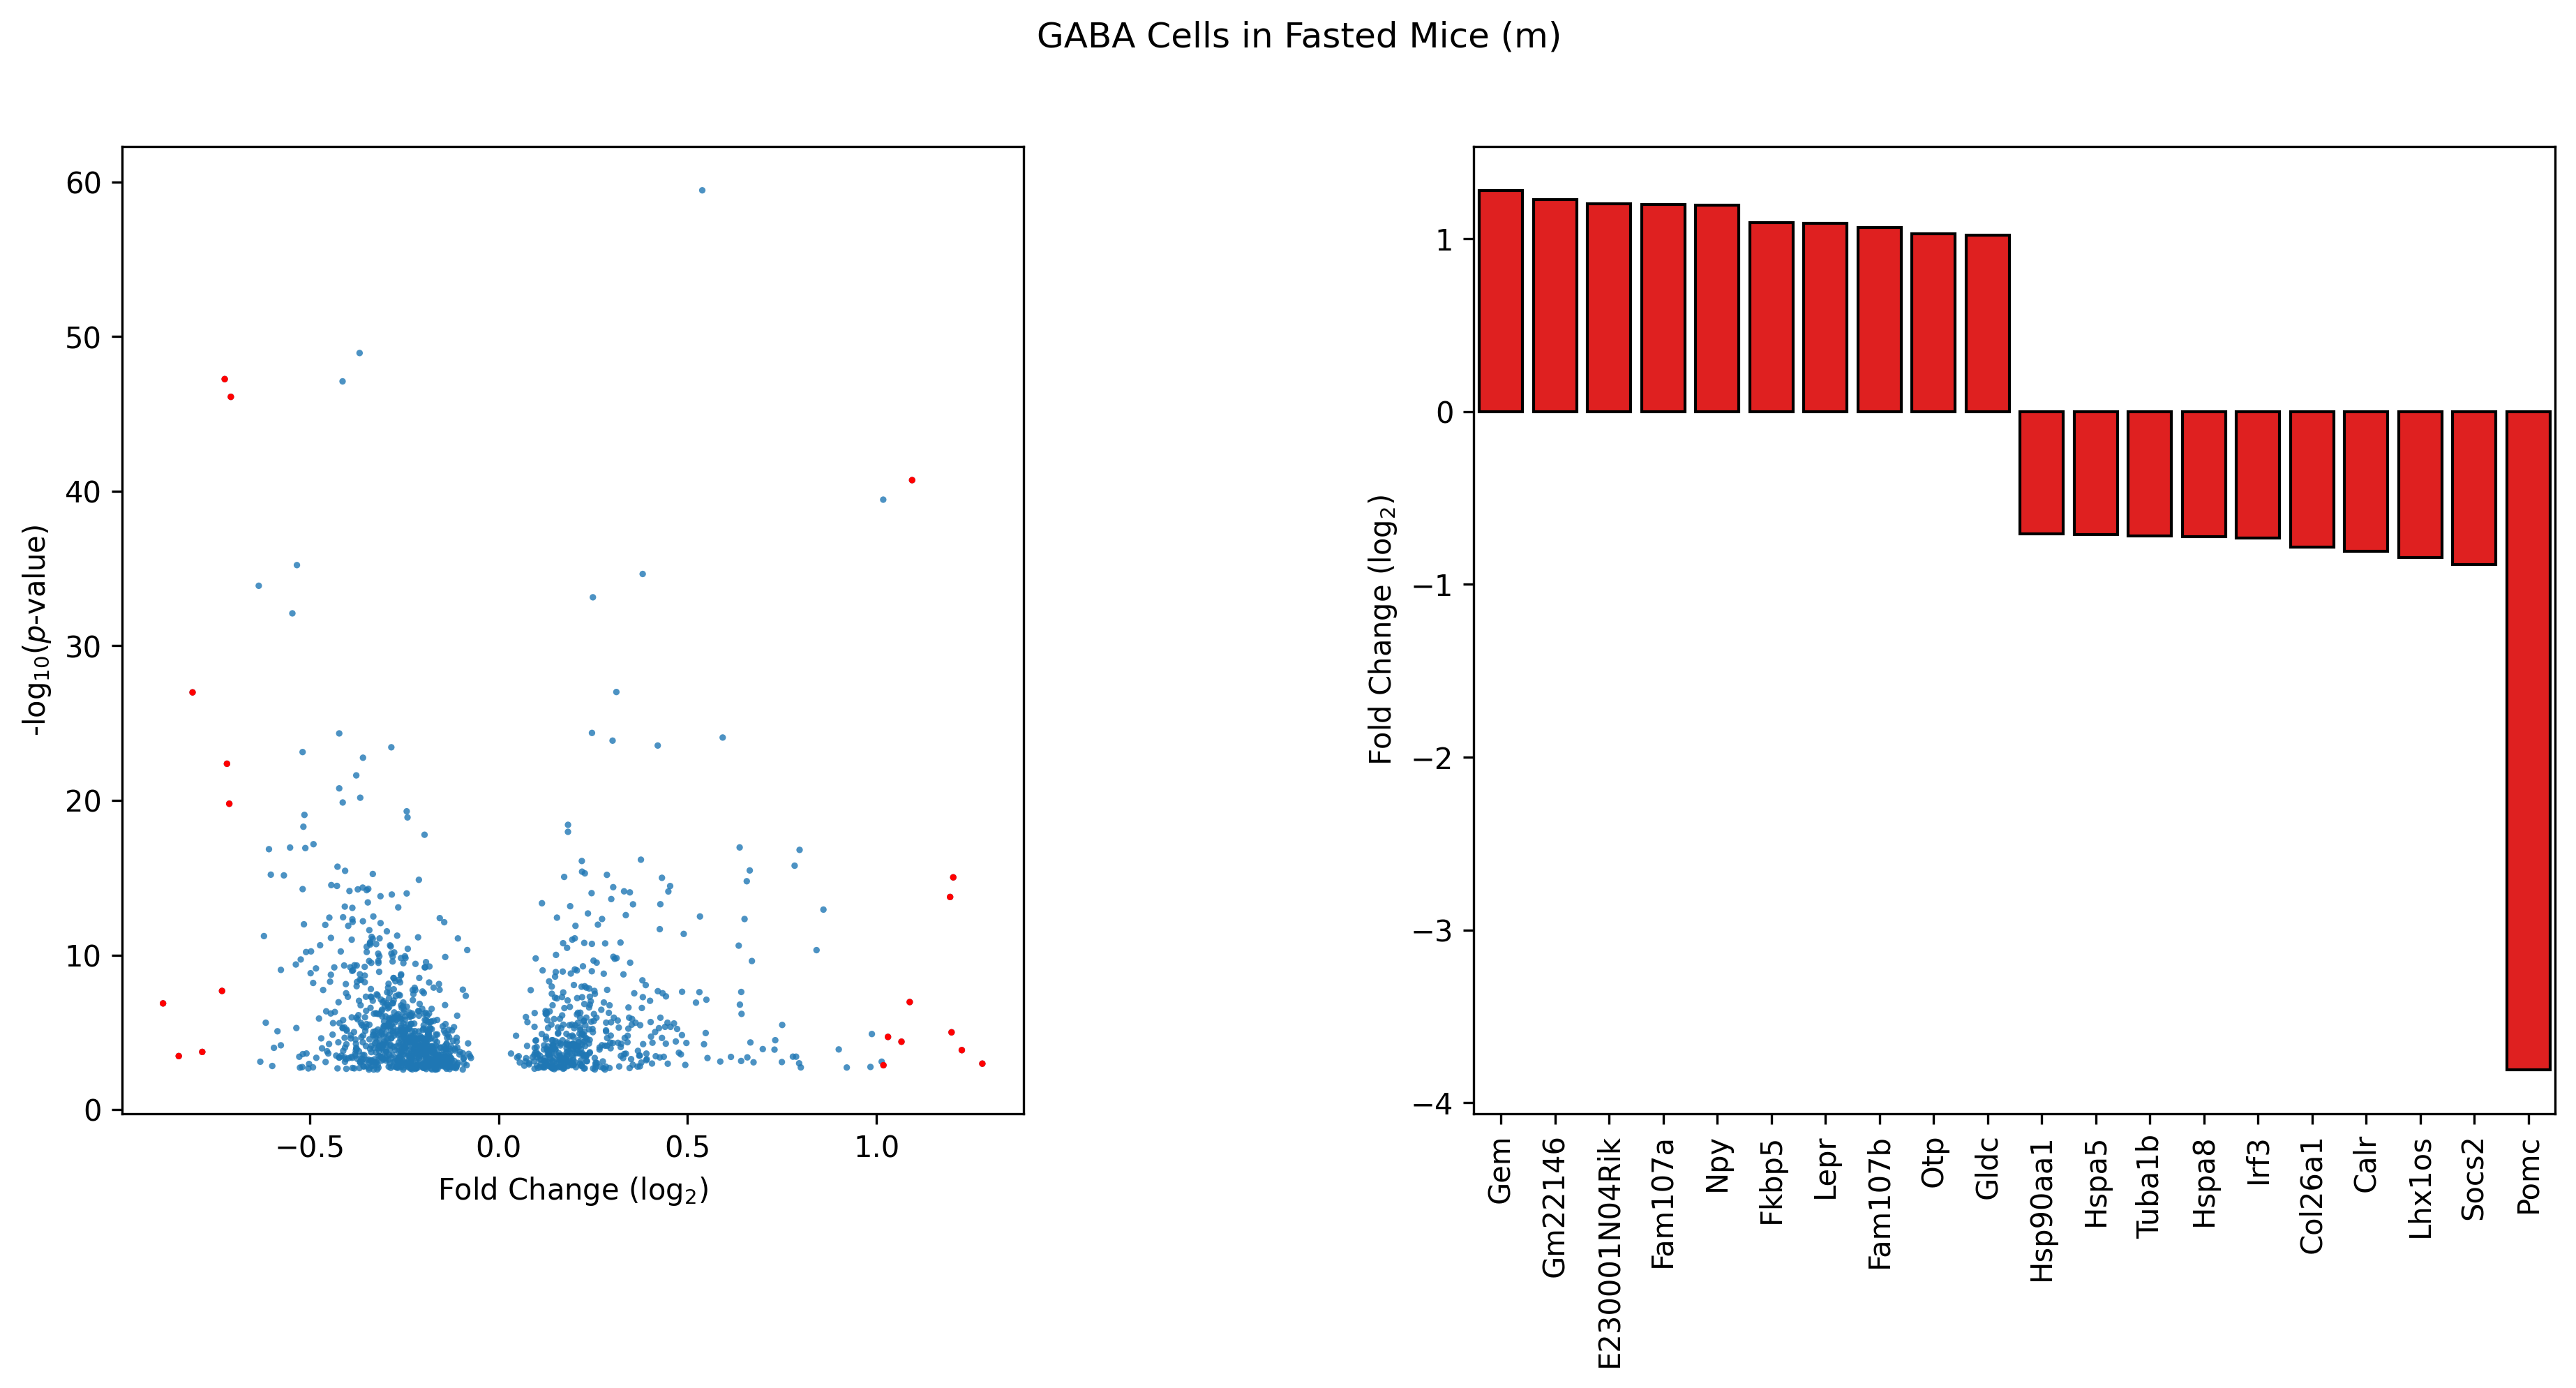


-------- m mice (Oligodendrocytes) --------


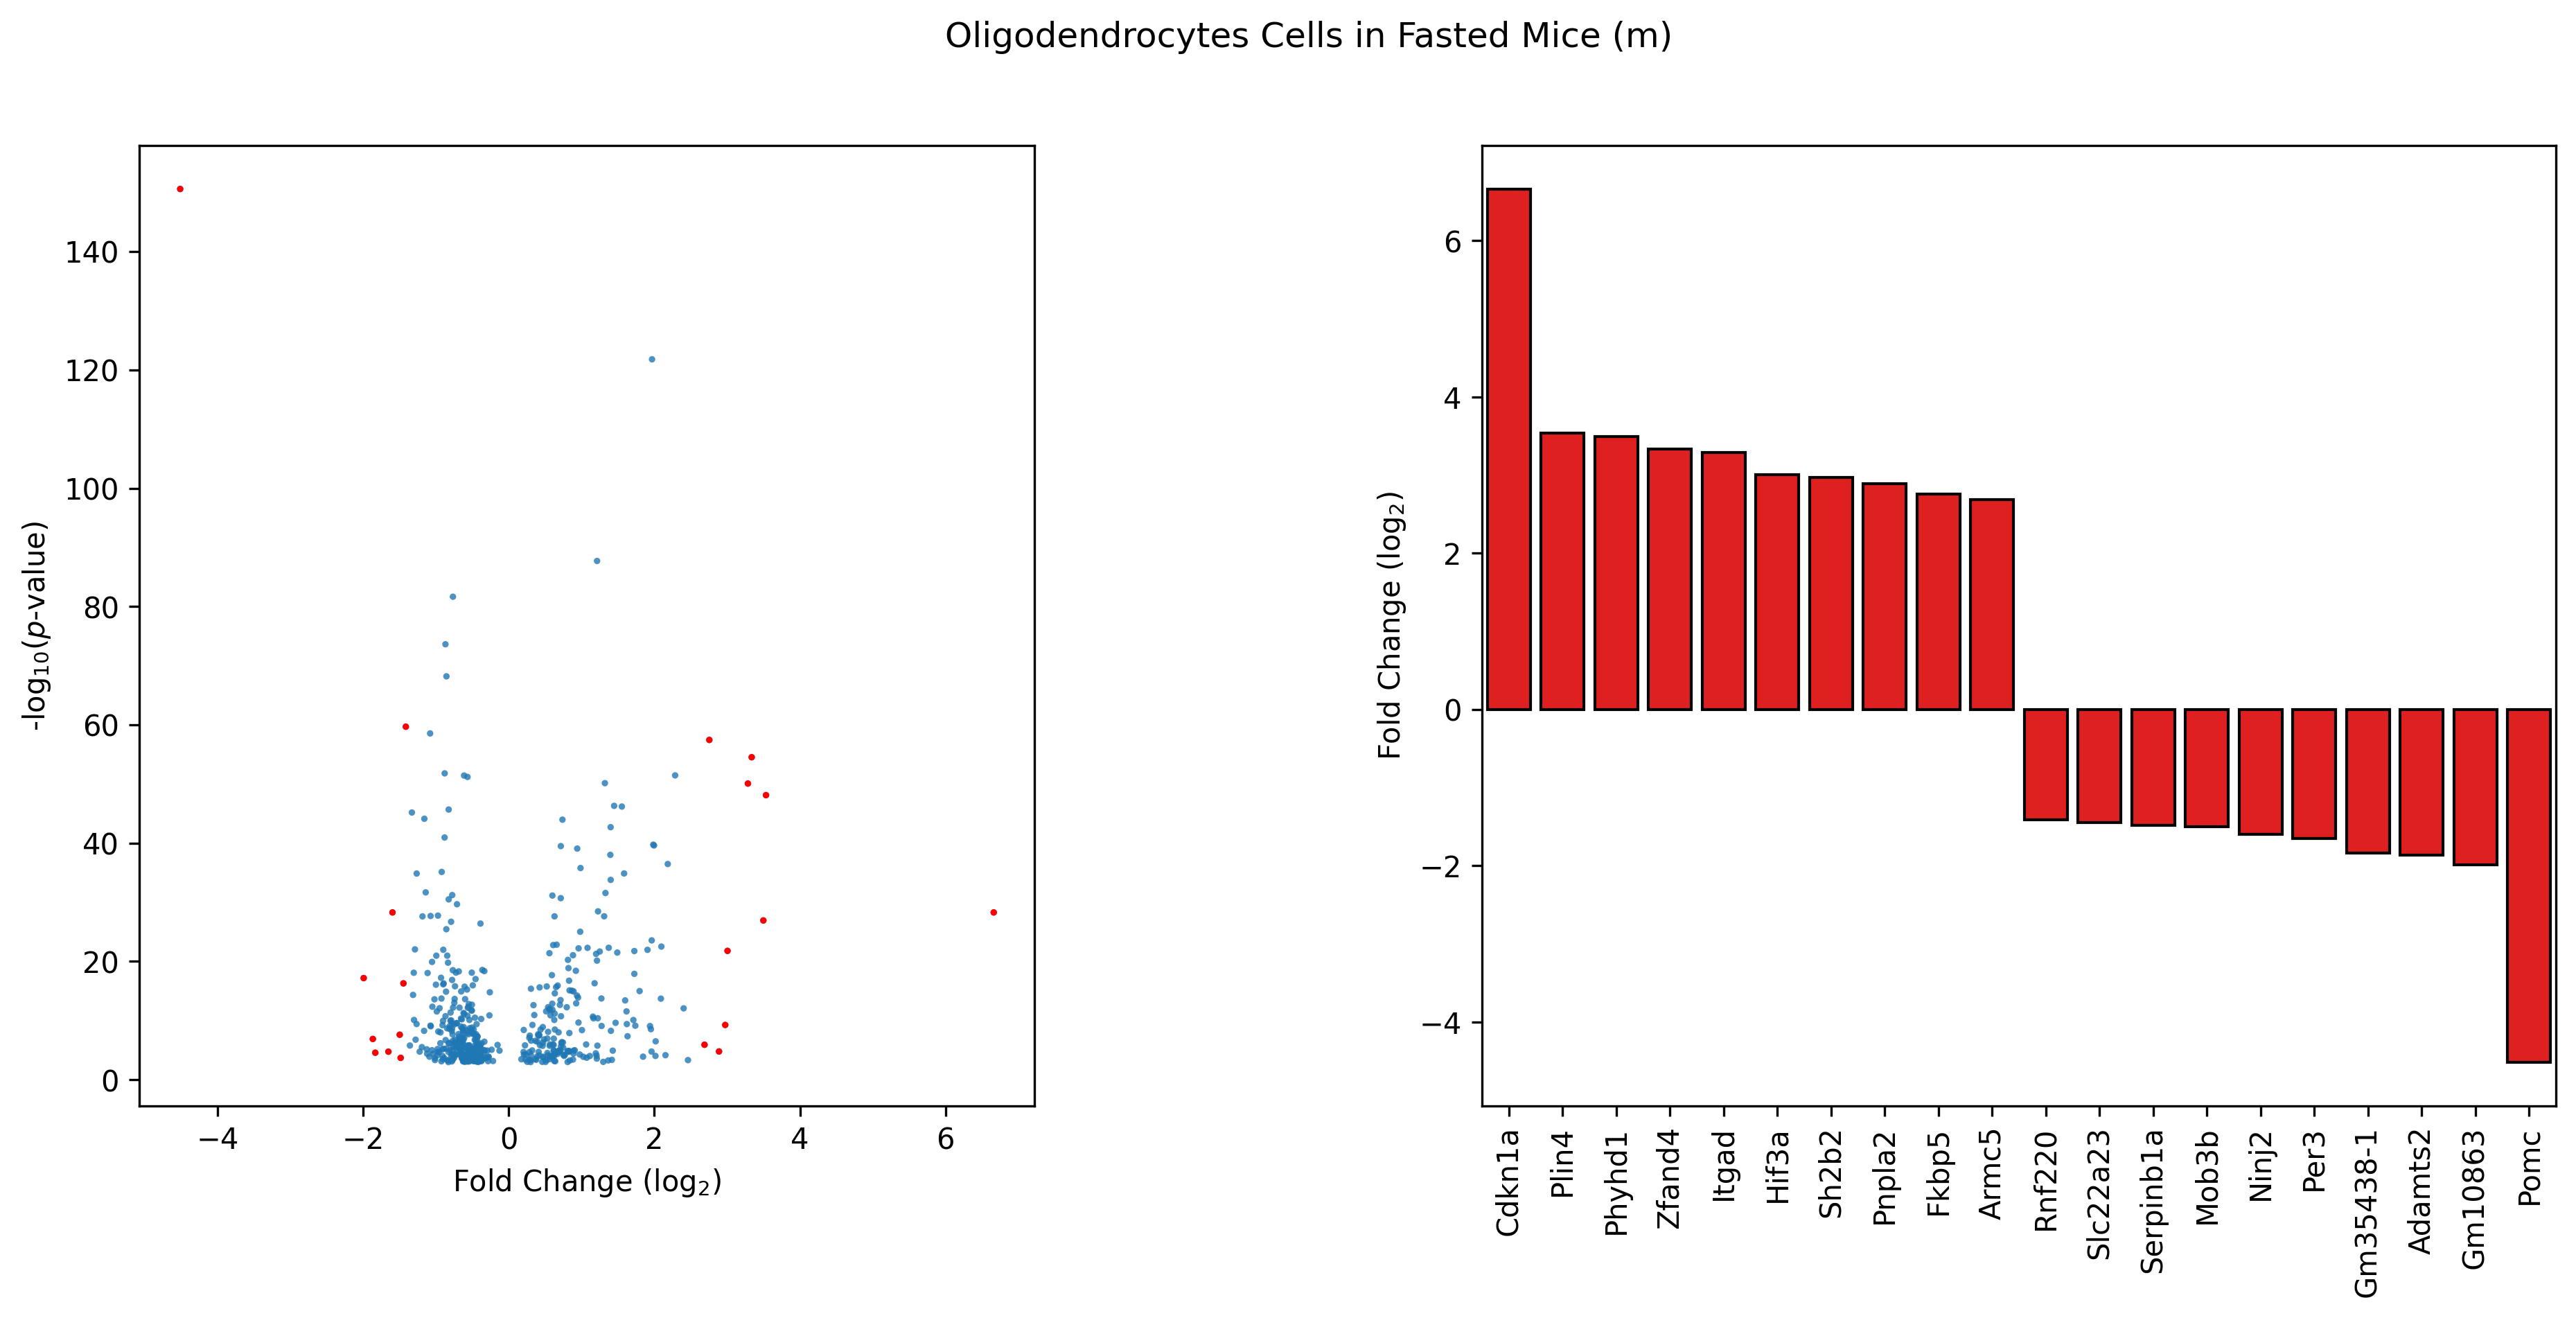


-------- m mice (GLU) --------


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


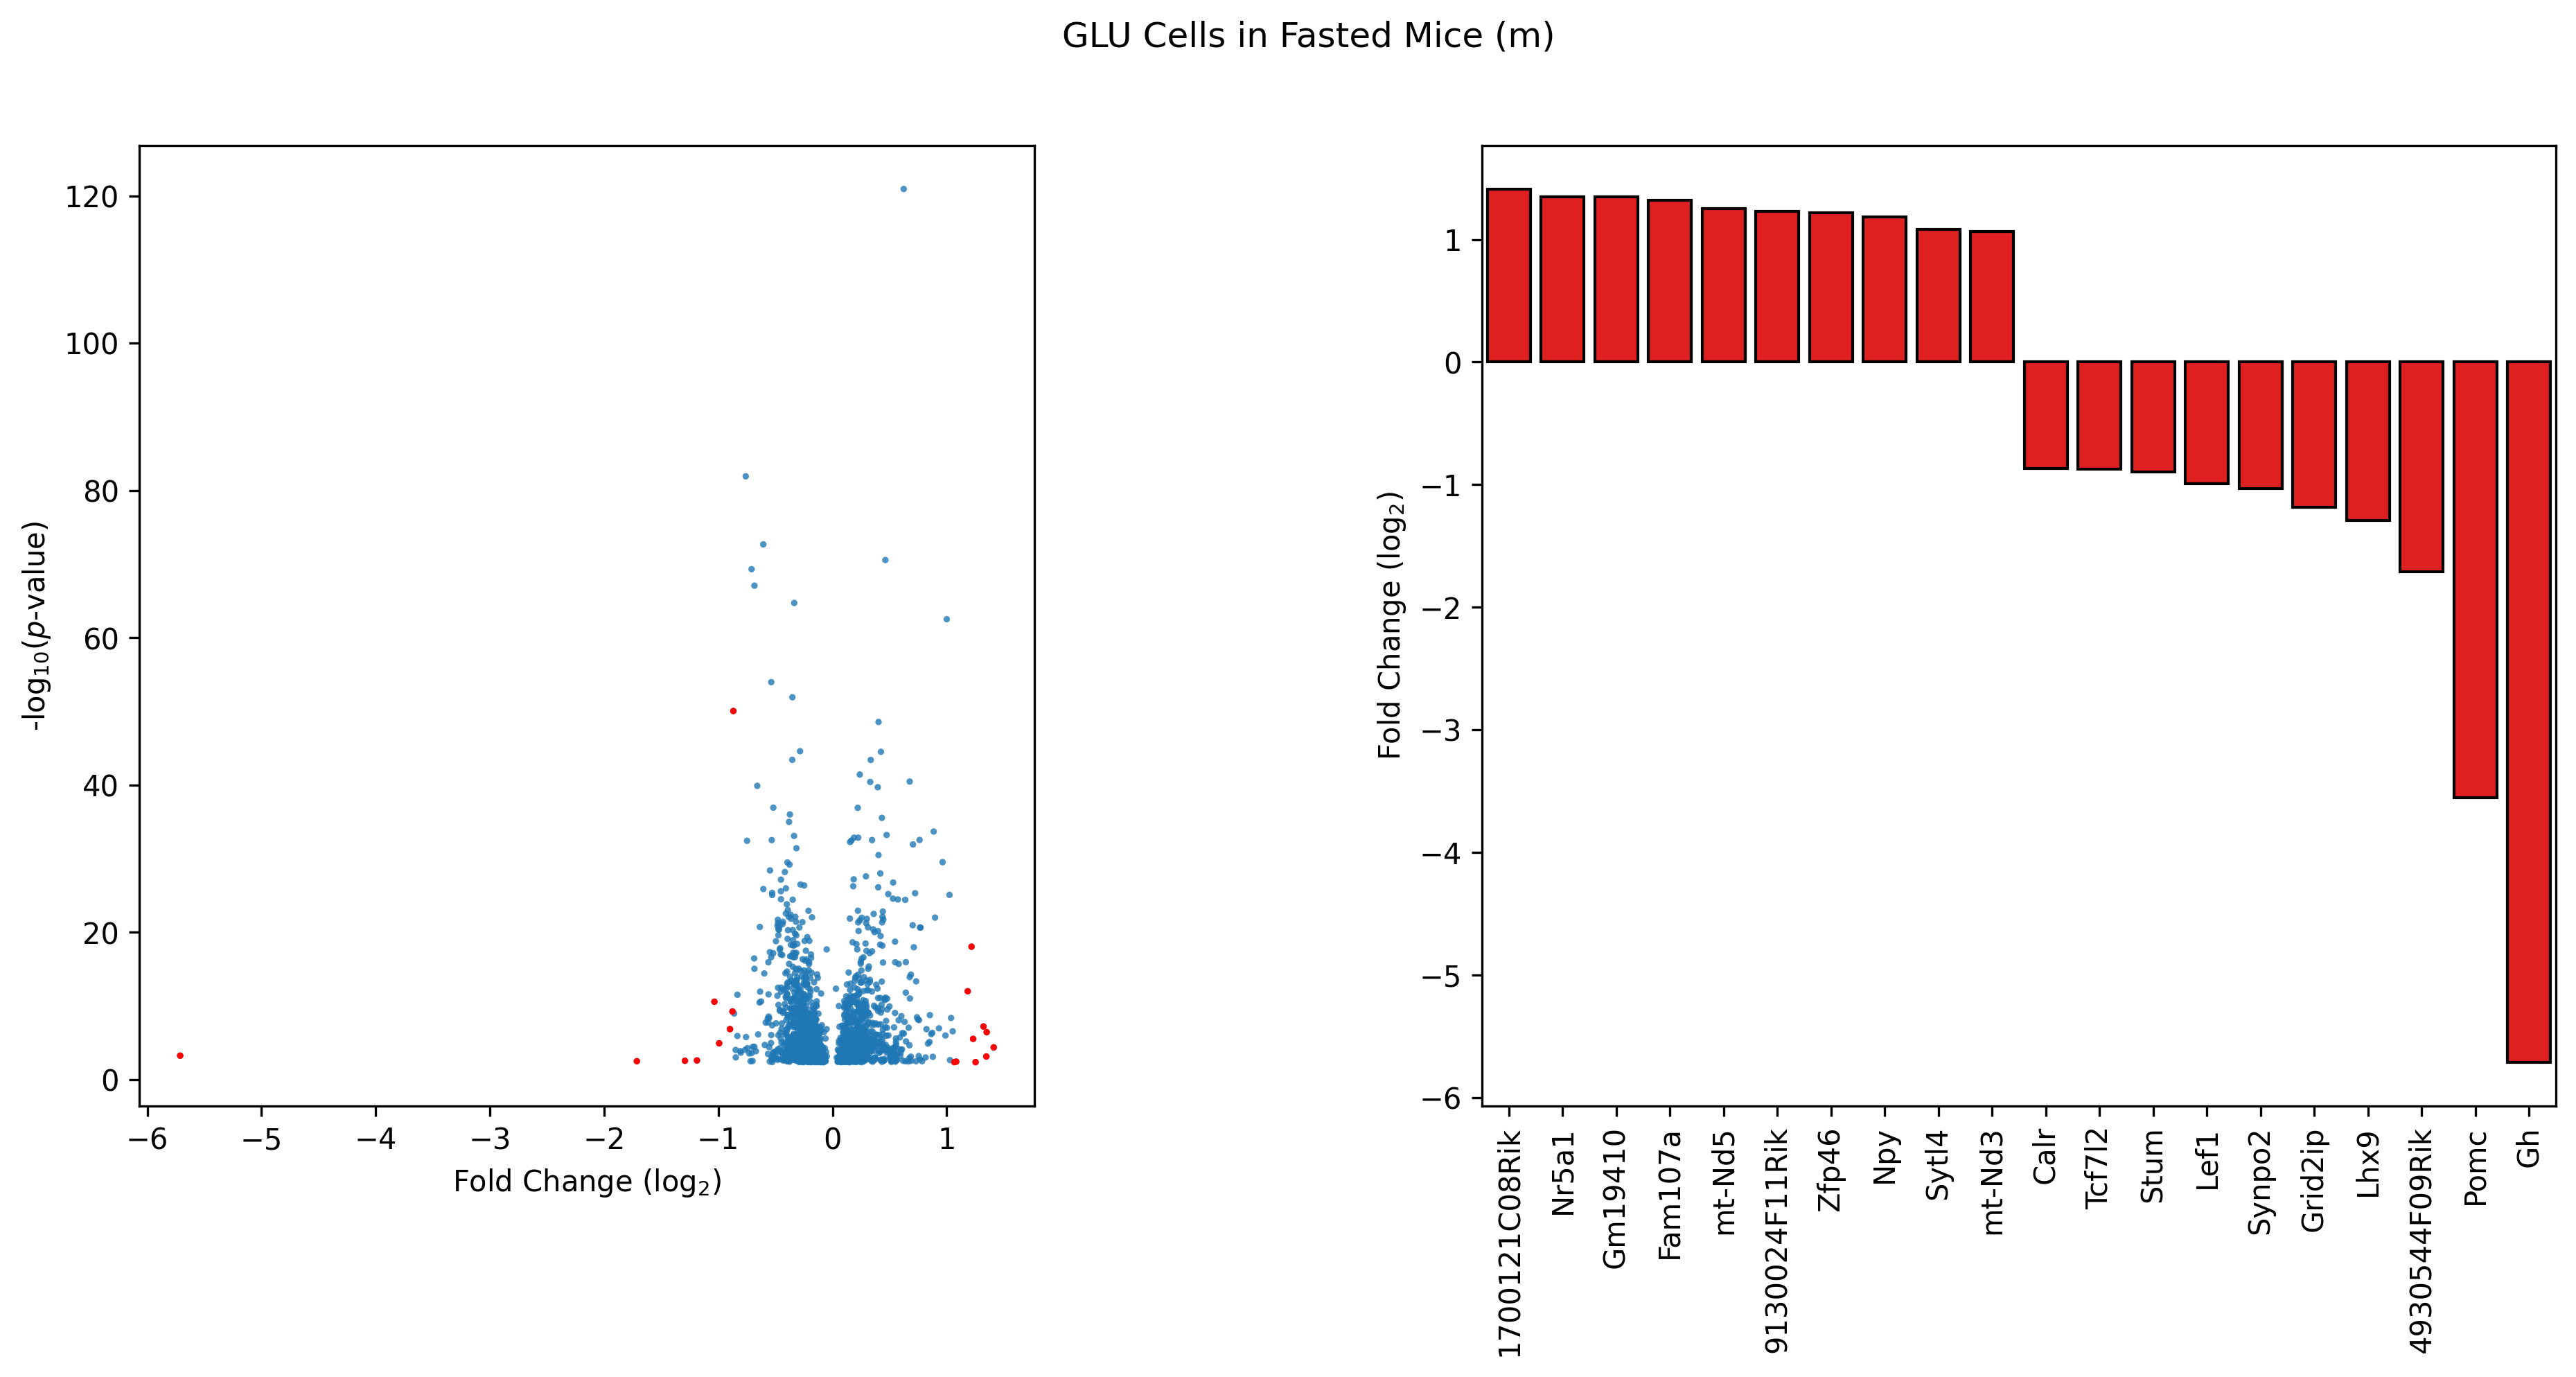


-------- m mice (Astrocytes) --------


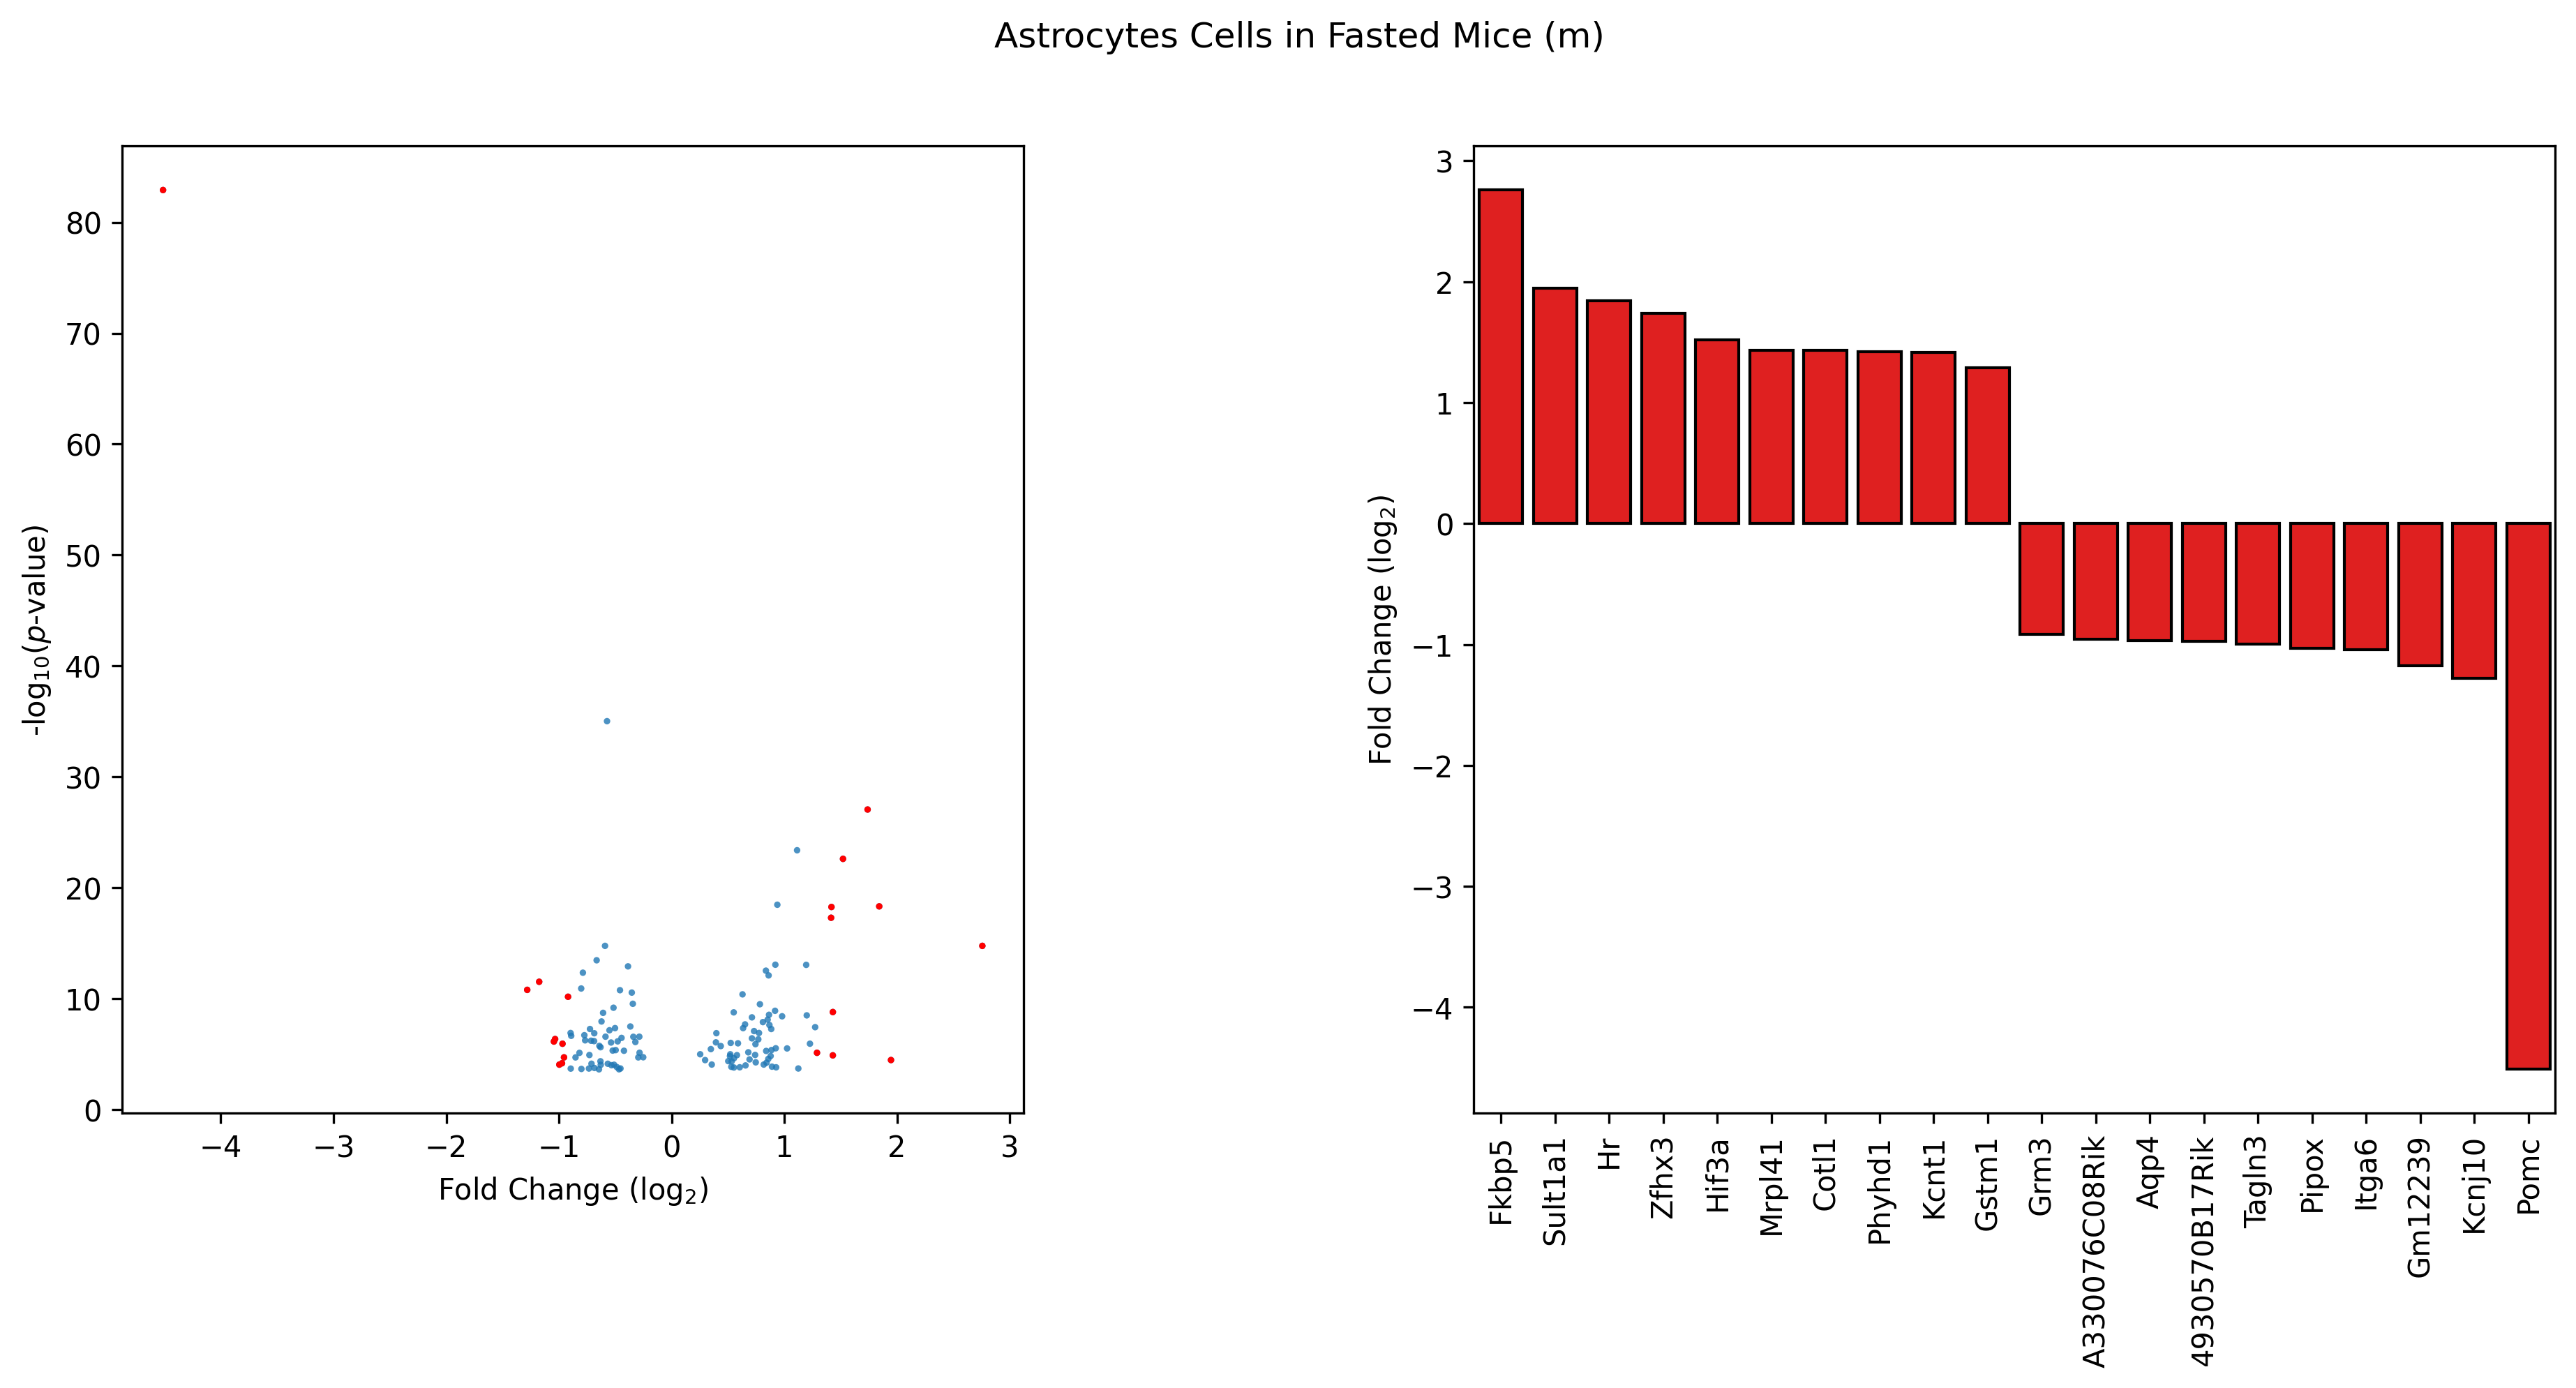


-------- f mice (GABA) --------


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


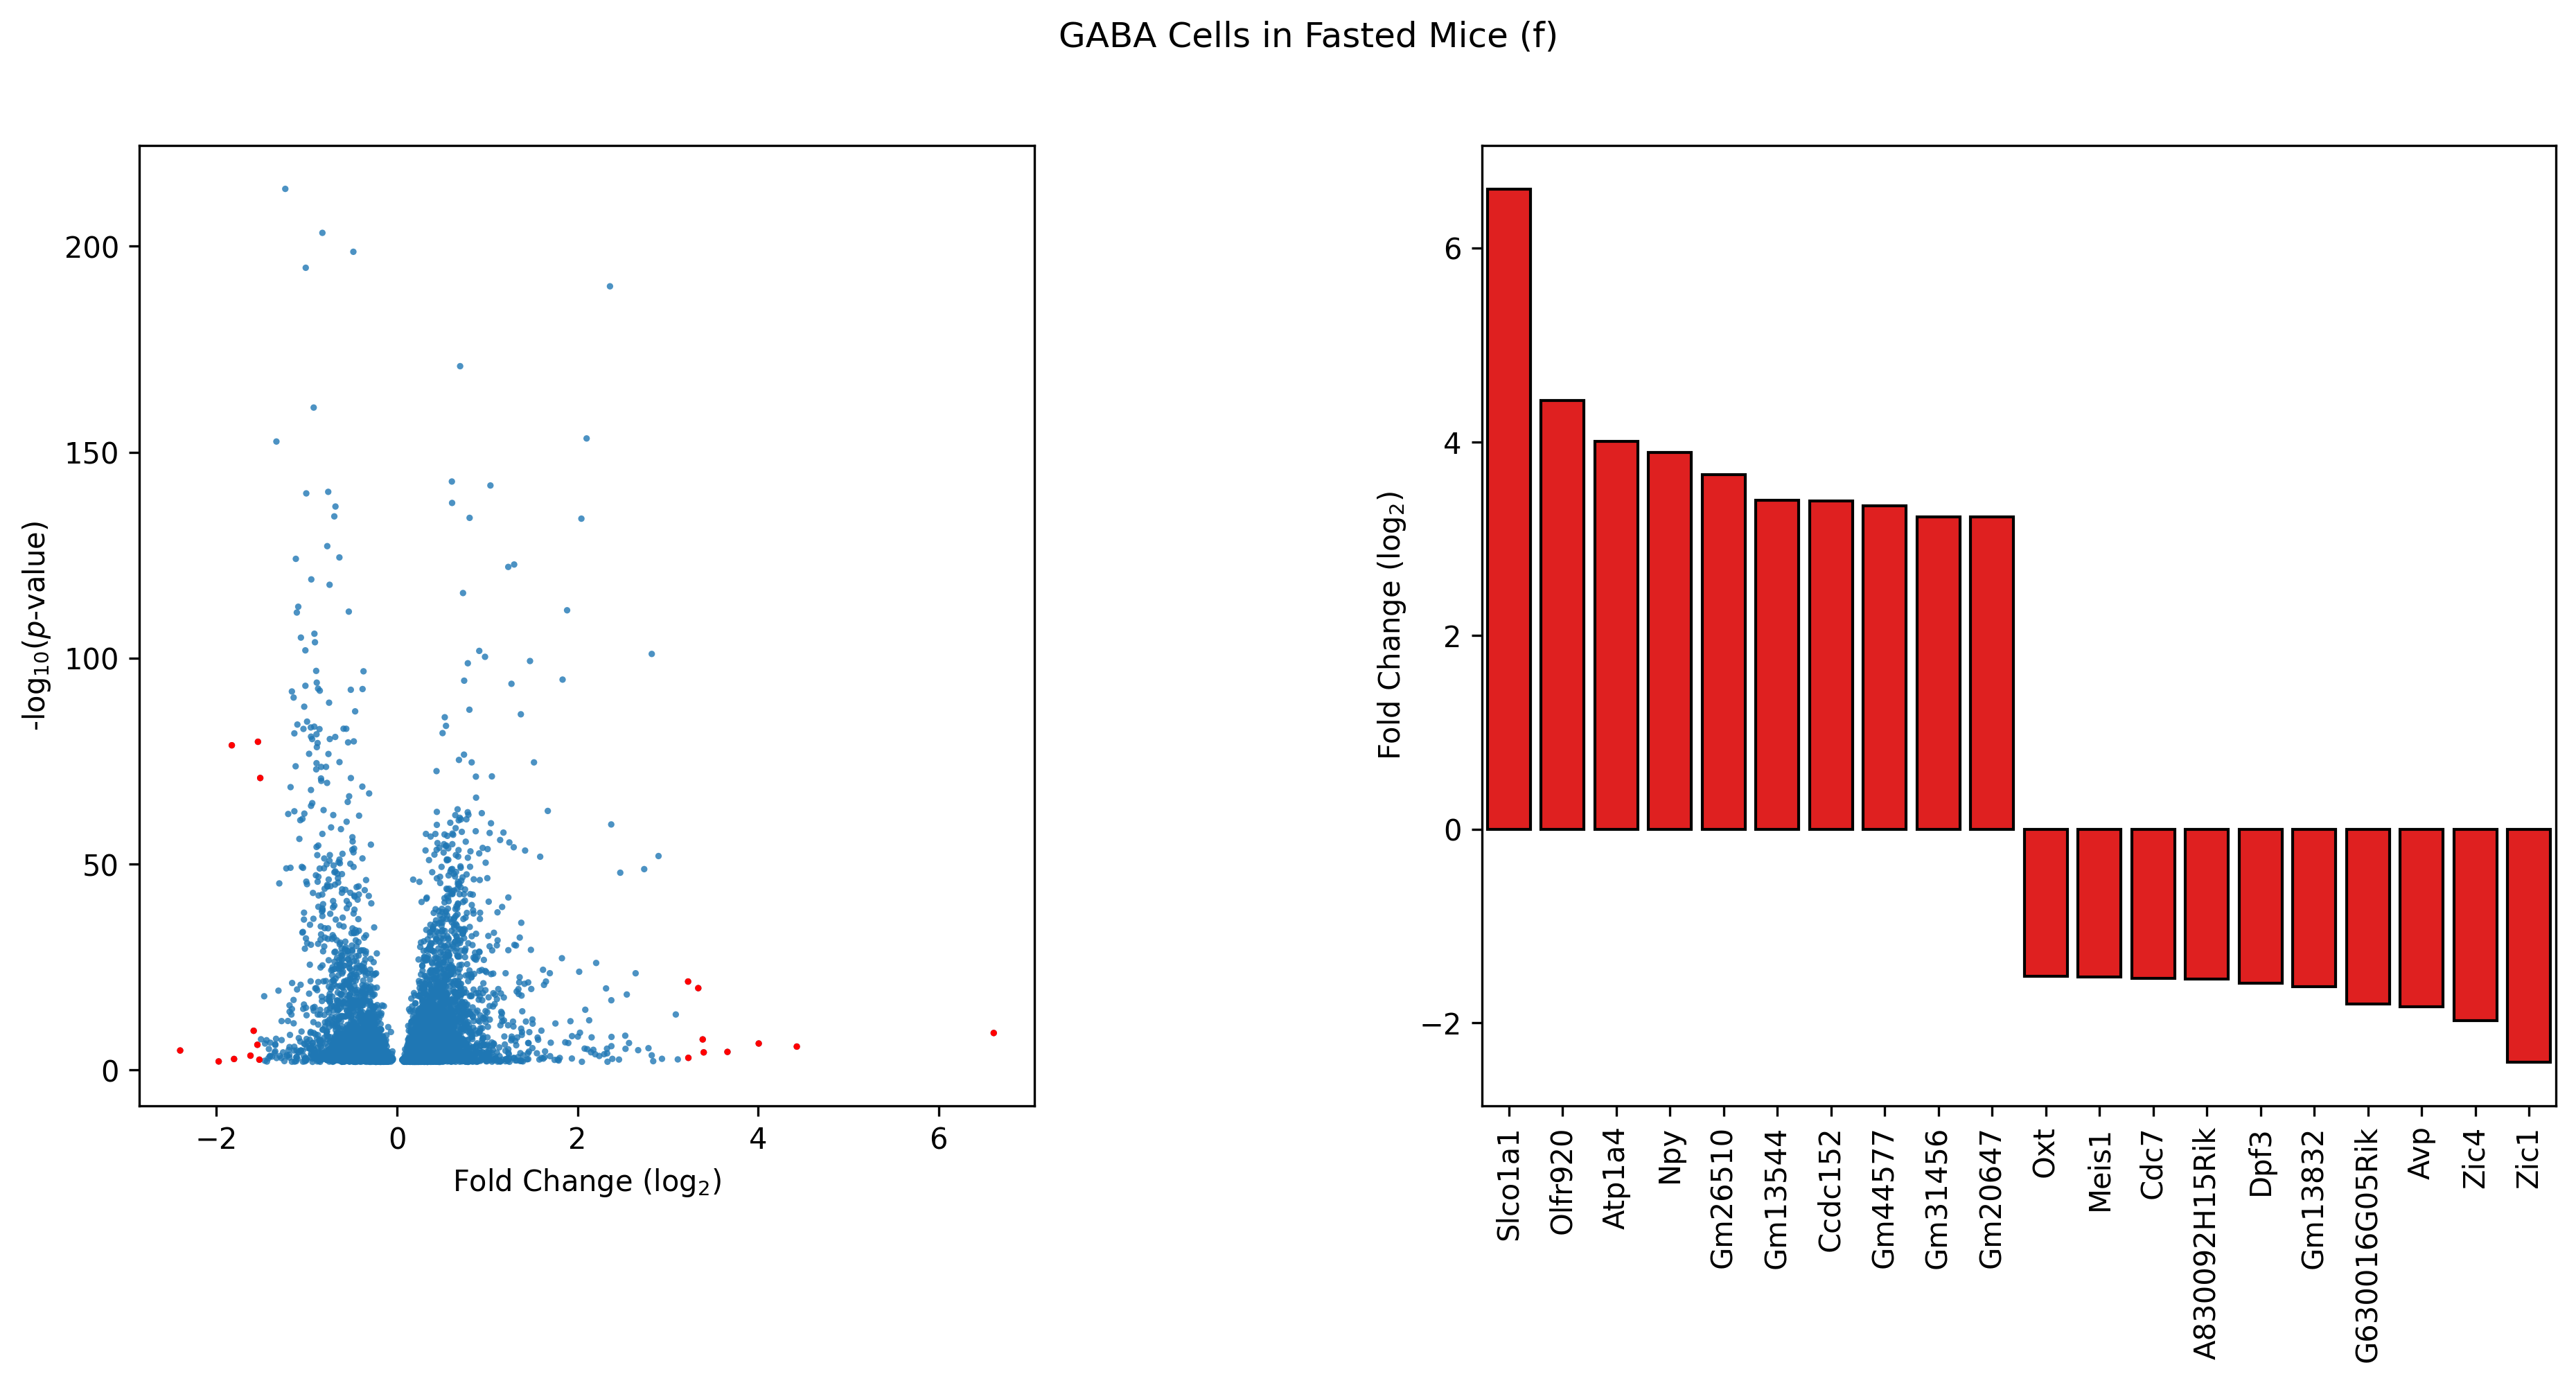


-------- f mice (Oligodendrocytes) --------


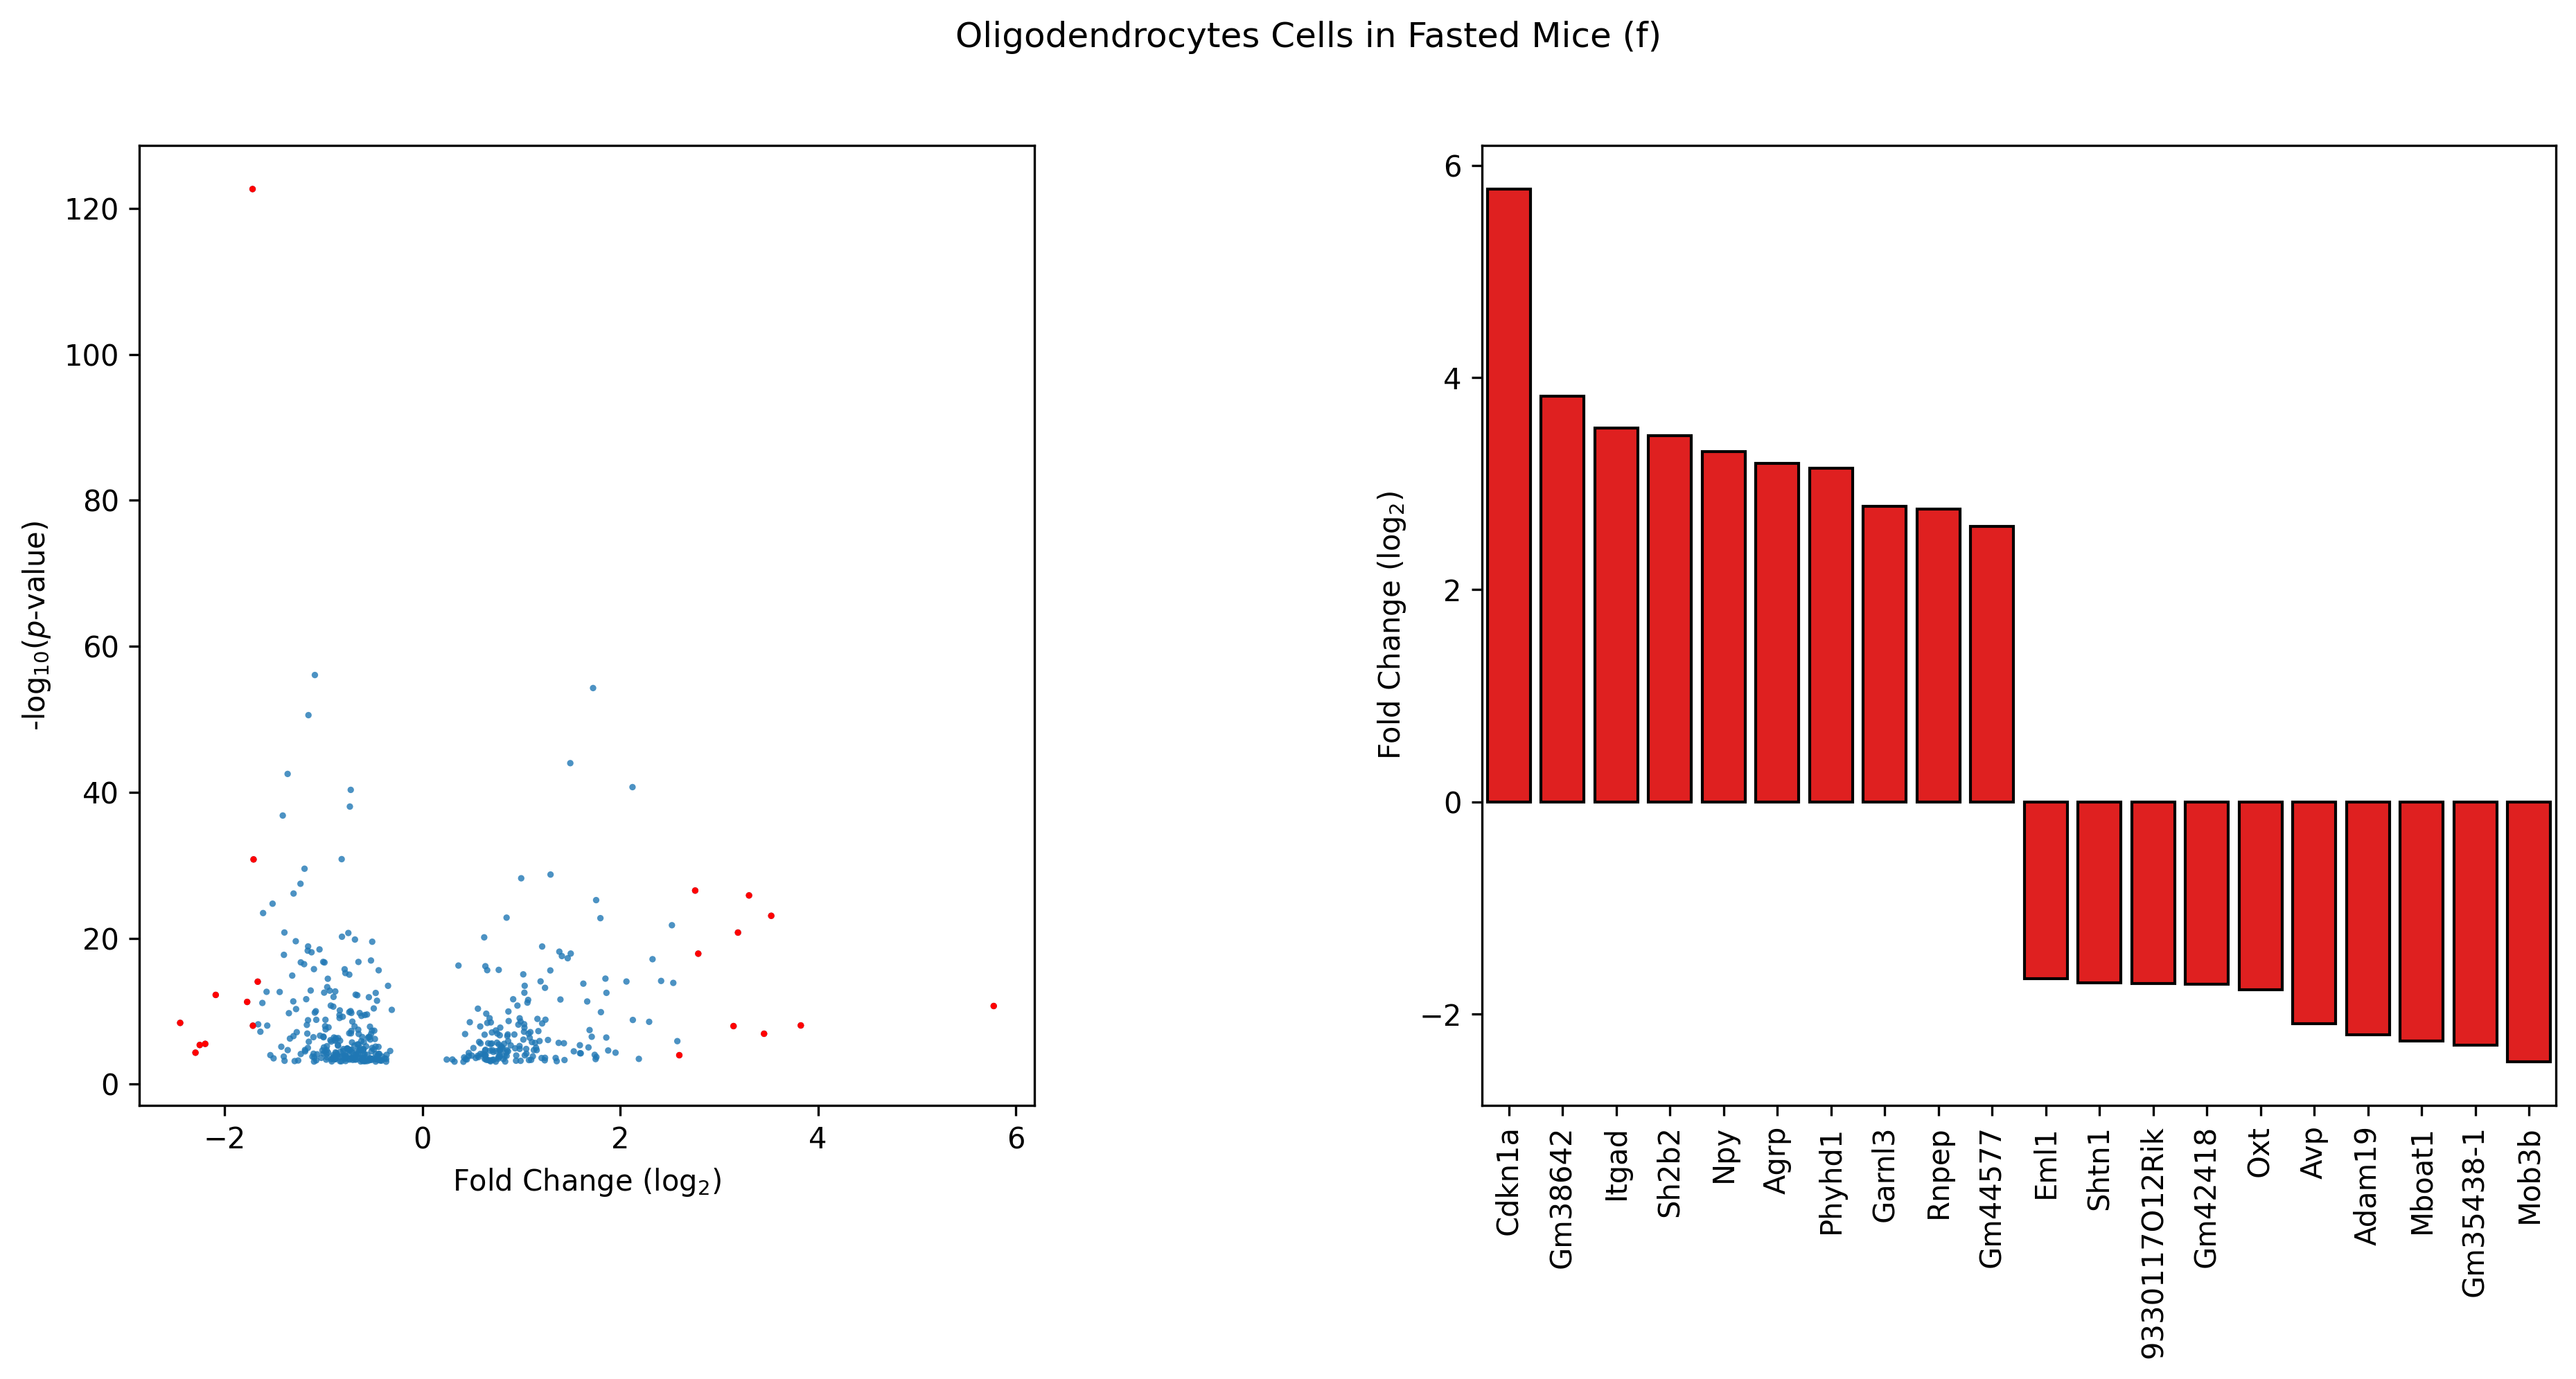


-------- f mice (GLU) --------


/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


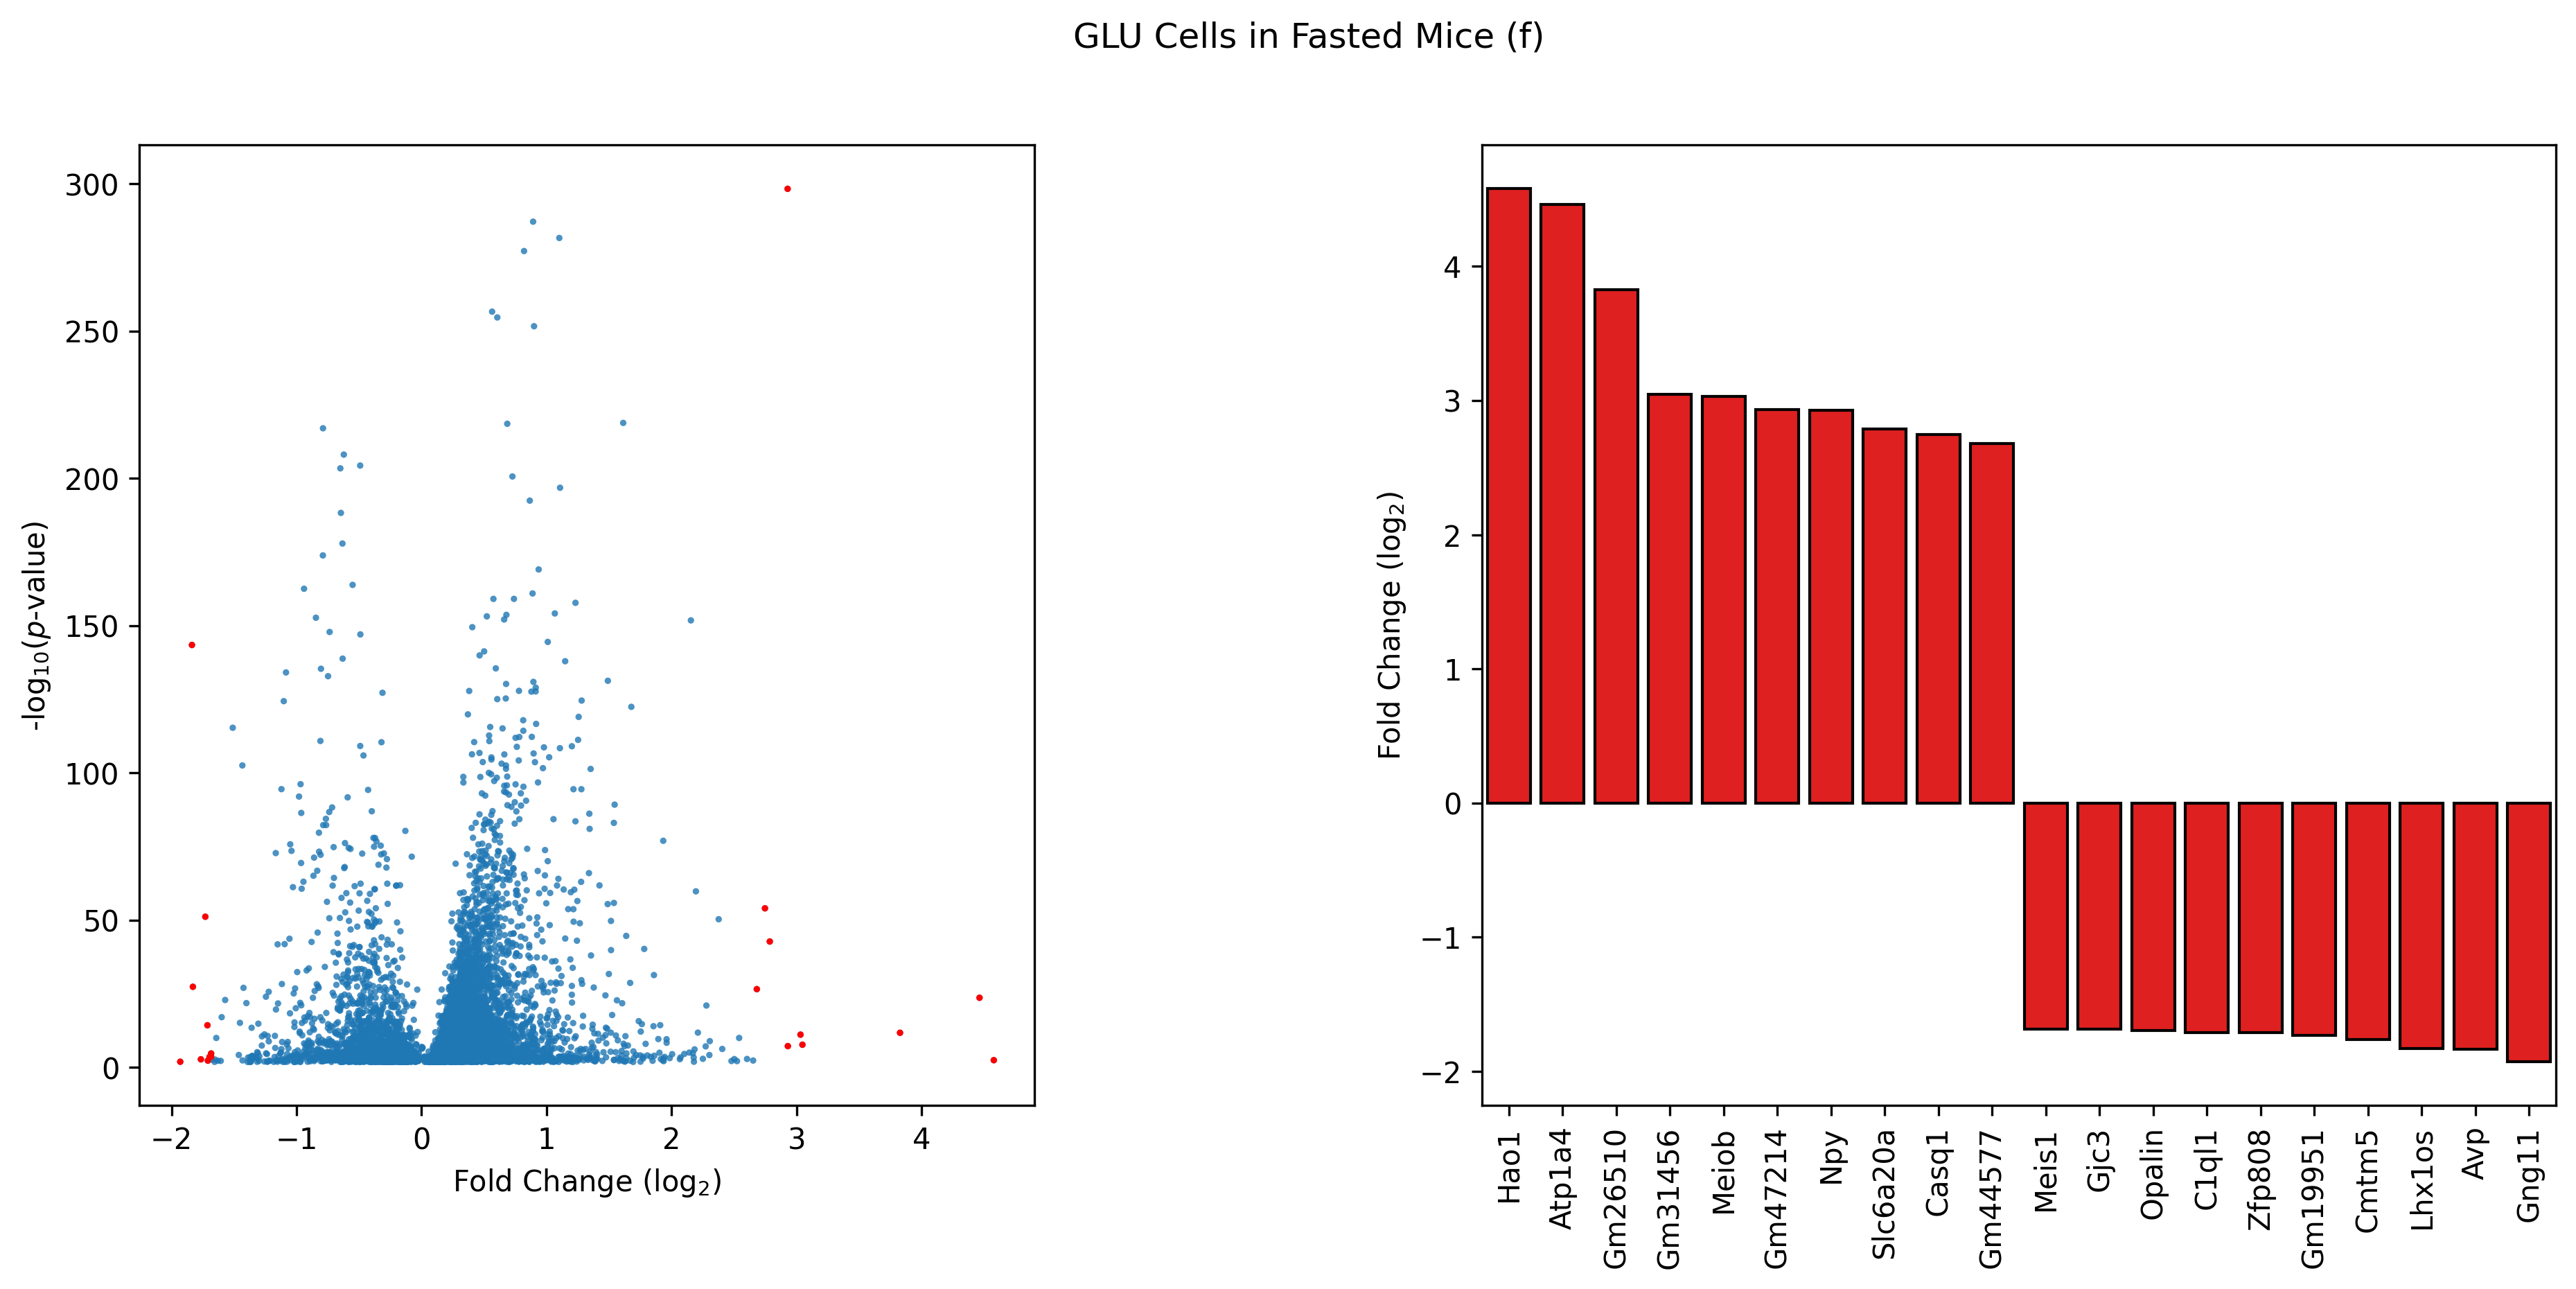


-------- f mice (Astrocytes) --------


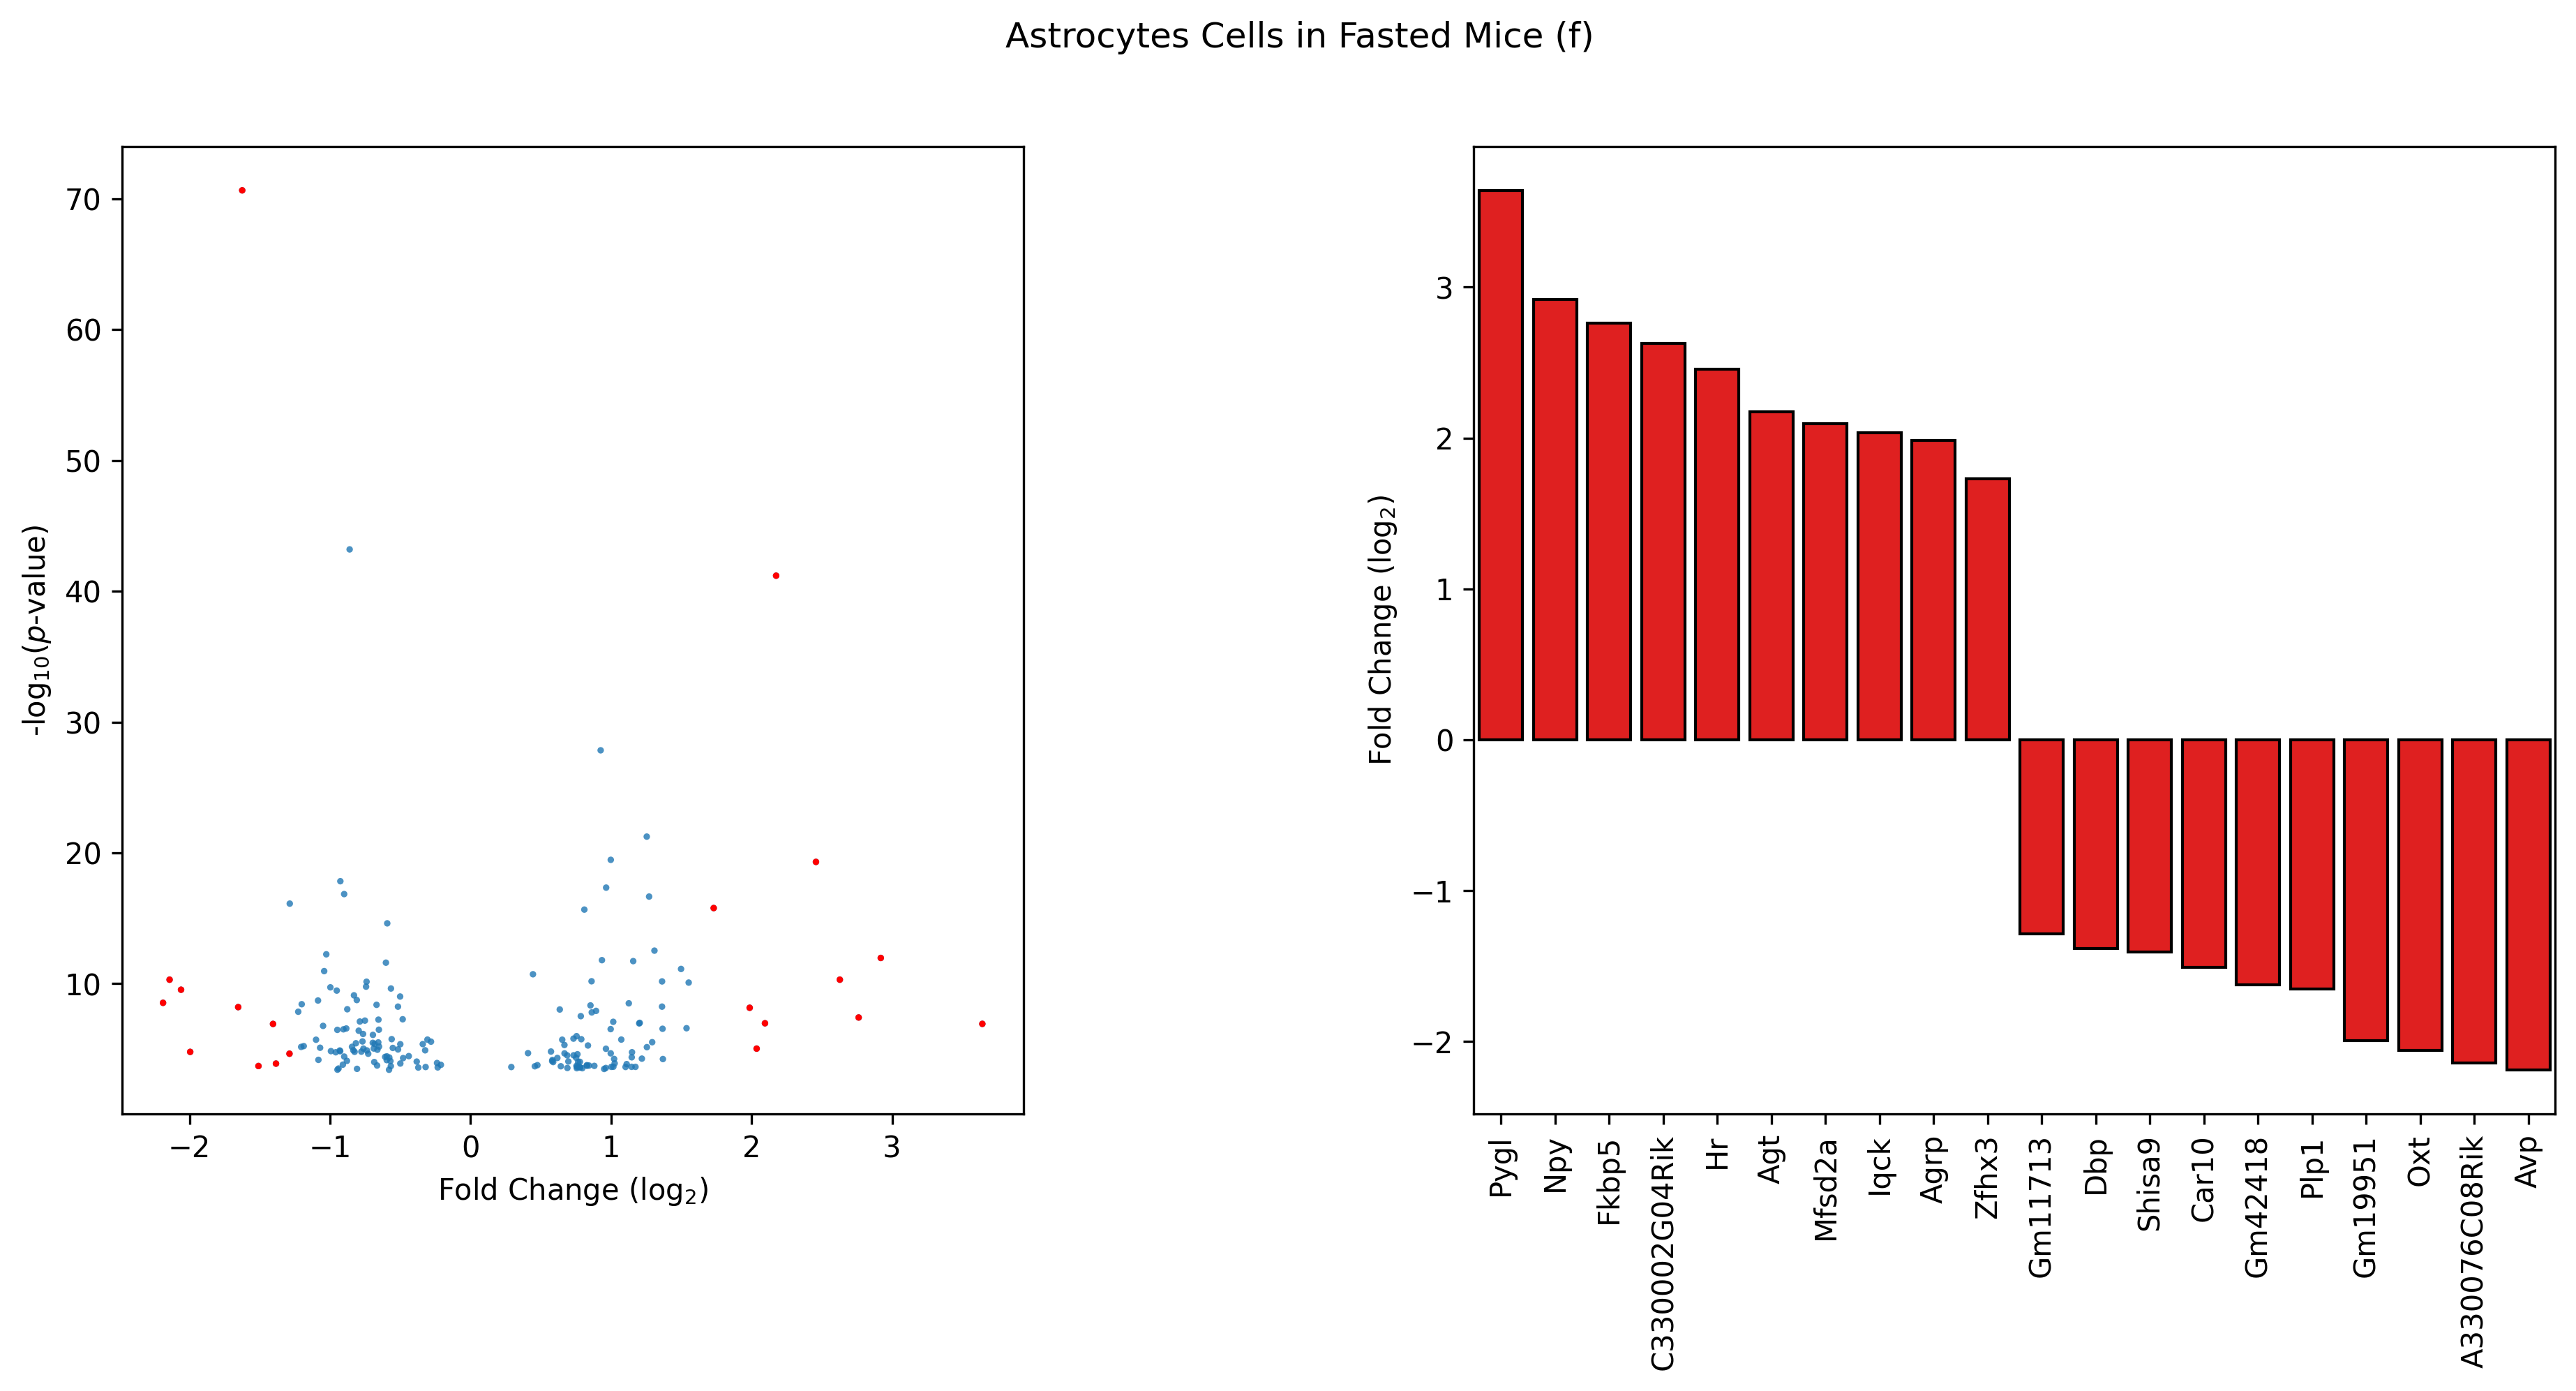

In [17]:
alpha = 0.05
n_print = 20
color_n = 10
key = 'Diet'

sexes = [
    'm',
    'f',
]

celltypes = [
    ' GABA', 
    ' Oligodendrocytes', 
    # ' Immune',
    ' GLU', 
    # ' OPC', 
    ' Astrocytes', 
    # ' Ependymal', 
    # ' Mural+Endothelial', 
    # ' Fibroblasts',
]

res = []

for sex in sexes:
    for ct in celltypes:
        print(f"\n-------- {sex} mice ({ct.strip()}) --------")
        tmp = adata[(adata.obs["Sex"] == sex) & (adata.obs["broad_type"] == ct)] 

        # get marker genes
        sc.tl.rank_genes_groups(tmp, 
                                groupby=key,
                                method='wilcoxon',
                                key_added=key,
                                corr_method='benjamini-hochberg')
    
    
        deg = sc.get.rank_genes_groups_df(tmp, 
                                          group='fasted',
                                          key=key)

        deg = deg[deg['pvals_adj'] <= alpha].reset_index(drop=True)
        deg['log10p'] = -1 * np.log10(deg['pvals'])
        deg = deg.sort_values(by='logfoldchanges', ascending=False)


        """ VOLCANO PLOTS """
        
        plt.rcParams['figure.dpi'] = 300
        plt.rcParams['figure.figsize'] = 15, 6

        sns.scatterplot(data=deg, 
                        x='logfoldchanges',
                        y='log10p',
                        ec='none',
                        alpha=0.8,
                        zorder=1,
                        s=5)

        plt.ylabel(r"-log$_{10}$($p$-value)")
        plt.xlabel(r"Fold Change (log$_{2}$)")

        """ ANNOTATE SOME POINTS """

        bookend = pd.concat([deg.head(color_n), deg.tail(color_n)])

        sns.scatterplot(data=bookend, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                color='r',
                alpha=1,
                zorder=4,
                s=5)

        ax = plt.gca()

        divider = make_axes_locatable(ax)
        ax2 = divider.append_axes("right", size="120%", pad="50%")

        sns.barplot(data=bookend,
                    y='logfoldchanges',
                    x='names',
                    ec='k',
                    color='r',
                    ax=ax2)

        ax2.set_ylabel(r"Fold Change (log$_{2}$)")
        ax2.set_xlabel("")
        ax2.tick_params(axis='x', rotation=90)

        plt.suptitle(f"{ct.strip()} Cells in Fasted Mice ({sex})")
        plt.show()

In [ ]:
break

In [ ]:
# n_print = 20
# n_query = 300
# alpha = 0.05
# sig = deg[deg['pvals_adj'] <= alpha]

# """Up in female """
# print(f"----- Upregulated genes in fasted cells -----")
# print(sig[['names', 'logfoldchanges']].head(n_print))


# """Up in female """
# sigm = sig[sig['group'] == 'fed']
# sigm = sigm.sort_values(by='logfoldchanges', ascending=False)

# print(f"----- Upregulated genes in Sun1+ cells (fed) -----")
# print(sigm[['names', 'logfoldchanges']].head(n_print))

In [ ]:
break

In [ ]:
# break

In [ ]:
def label_point(x, y, val, ax, offset=(0.0, 0.0)):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+ offset[0], point['y'] + offset[1], str(point['val']), fontsize=4,)

In [ ]:
alpha = 0.05
plot_top = 10
lcft = 2

deg = sc.get.rank_genes_groups_df(sun, 
                                  group='fasted',
                                  key=key)

deg['log10p'] = -1 * np.log10(deg['pvals'])

deg = deg[deg['pvals_adj'] <= alpha]

deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 2

sns.scatterplot(data=deg, 
            x='logfoldchanges',
            y='log10p',
            ec='none',
            alpha=0.8,
            c=deg['color'].to_list(),
            zorder=1,
            s=5)

plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")

plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)

hi_deg = deg[deg['logfoldchanges'] > lcft]
hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
hi_deg = hi_deg.head(plot_top)

divider = make_axes_locatable(plt.gca())
ax2 = divider.append_axes("right", size="120%", pad="35%")

sns.barplot(data=hi_deg,
            y='logfoldchanges',
            x='names',
            ec='k',
            color='r',
            ax=ax2)

ax2.set_ylabel(r"Fold Change (log$_{2}$)")
ax2.set_xlabel("")
ax2.tick_params(axis='x', rotation=90)

sns.despine()

hi_deg

In [ ]:
""" By cell type """

alpha = 0.05
plot_top = 10
lcft = 2
key = 'Diet'

ctypes = [
    ' GABA',
    ' GLU',
    
]

for ctype in ctypes:
    tmp = sun[sun.obs["broad_type"] == ctype] 

    # get marker genes
    sc.tl.rank_genes_groups(tmp, 
                            groupby=key,
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')



    deg = sc.get.rank_genes_groups_df(tmp, 
                                      group='fasted',
                                      key=key)
    
    deg['log10p'] = -1 * np.log10(deg['pvals'])
    deg = deg[deg['pvals_adj'] <= alpha]
    deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 6, 2
    
    sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.8,
                c=deg['color'].to_list(),
                zorder=1,
                s=5)

    plt.ylabel(r"-log$_{10}$($p$-value)")
    plt.xlabel(r"Fold Change (log$_{2}$)")
    
    
    plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
    plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)
    
    hi_deg = deg[deg['logfoldchanges'] > lcft]
    hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
    hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
    hi_deg = hi_deg.head(plot_top)
    
    divider = make_axes_locatable(plt.gca())
    ax2 = divider.append_axes("right", size="120%", pad="35%")
    
    sns.barplot(data=hi_deg,
                y='logfoldchanges',
                x='names',
                ec='k',
                color='r',
                ax=ax2)
    
    ax2.set_ylabel(r"Fold Change (log$_{2}$)")
    ax2.set_xlabel("")
    ax2.tick_params(axis='x', rotation=90)
    
    sns.despine()
    plt.suptitle(f"{ctype.strip()} Neurons")
    plt.show()
    
    print(hi_deg)
    print()
    # break

In [ ]:
""" By sex """

alpha = 0.05
plot_top = 10
lcft = 1
key = 'Diet'

sexes = ['m','f',]

for sex in sexes:
    tmp = sun[sun.obs["Sex"] == sex] 

    # get marker genes
    sc.tl.rank_genes_groups(tmp, 
                            groupby=key,
                            method='wilcoxon',
                            key_added=key,
                            corr_method='benjamini-hochberg')


    deg = sc.get.rank_genes_groups_df(tmp, 
                                      group='fasted',
                                      key=key)
    
    deg['log10p'] = -1 * np.log10(deg['pvals'])
    deg = deg[deg['pvals_adj'] <= alpha]
    deg['color'] = np.where(deg['logfoldchanges'] > lcft, 'r', 'lightgrey')

    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 6, 2
    
    sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.8,
                c=deg['color'].to_list(),
                zorder=1,
                s=5)

    plt.ylabel(r"-log$_{10}$($p$-value)")
    plt.xlabel(r"Fold Change (log$_{2}$)")
    
    
    plt.axvline(x=2, lw=1, c='k', ls=':', zorder=2)
    plt.axvline(x=-2, lw=1, c='k', ls=':', zorder=2)
    
    hi_deg = deg[deg['logfoldchanges'] > lcft]
    hi_deg = hi_deg[~hi_deg['names'].str.contains('Gm')]
    hi_deg = hi_deg.sort_values(by='logfoldchanges', ascending=False)
    hi_deg = hi_deg.head(plot_top)
    
    divider = make_axes_locatable(plt.gca())
    ax2 = divider.append_axes("right", size="120%", pad="35%")
    
    sns.barplot(data=hi_deg,
                y='logfoldchanges',
                x='names',
                ec='k',
                color='r',
                ax=ax2)
    
    ax2.set_ylabel(r"Fold Change (log$_{2}$)")
    ax2.set_xlabel("")
    ax2.tick_params(axis='x', rotation=90)
    
    sns.despine()
    plt.suptitle(f"{sex.strip()}")
    plt.show()
    
    print(hi_deg)
    print()
    # break

In [ ]:
# # db = 'GO_Biological_Process_2023'
# db = 'GO_Biological_Process_2021'
# # db = 'KEGG_2021_Human'
# # db = 'TRANSFAC_and_JASPAR_PWMs'

# e_alpha = 0.05

# edf = gget.enrichr(sigf['names'].head(n_query).to_list(), database=db)
# # edf = edf[edf['adj_p_val'] <= e_alpha]
# pd.set_option('display.max_colwidth', 150)
# print(edf[['path_name', 'adj_p_val', 'overlapping_genes']])
# print()


In [ ]:
break

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

In [ ]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]



In [ ]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

In [ ]:
break

In [ ]:
break